In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-15 20:04:52.508262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744736692.524098   99095 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744736692.528940   99095 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744736692.541556   99095 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744736692.541573   99095 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744736692.541575   99095 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
precision_30000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/30000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/30000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        precision_30000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(precision_30000).transpose().to_dict()
    print(x)
    with open('results_30000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_30000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_30000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_30000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
217888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
217889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
217890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
217891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
217892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
217888    Bruteforce
217889    Bruteforce
217890    Bruteforce
217891    Bruteforce
217892    Bruteforce
Name: Attack Type, Length: 217893, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((185209, 46), (185209,), (32684, 46), (32684,))

# K Nearest Neighbour

In [16]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 35.6 s, sys: 18 ms, total: 35.6 s
Wall time: 9.04 s


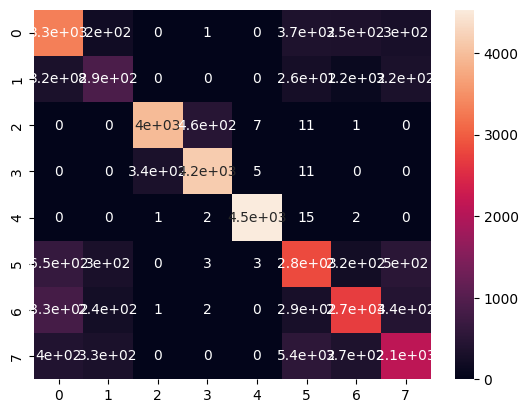

In [17]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [18]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [19]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [20]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [21]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801


{'precision': {'Benign': 0.7330536542283065, 'Bruteforce': 0.46561679790026245, 'DDoS': 0.8918675377337238, 'DoS': 0.9221729490022172, 'Mirai': 0.99560536145902, 'Recon': 0.6285905143620575, 'Spoofing': 0.6006666666666667, 'Web': 0.5642458100558659}, 'recall': {'Benign': 0.6018854242204495, 'Bruteforce': 0.4537084398976982, 'DDoS': 0.9215549348230913, 'DoS': 0.8986603284356093, 'Mirai': 0.9967003959524857, 'Recon': 0.6539263377345379, 'Spoofing': 0.7194570135746606, 'Web': 0.5780866721177432}, 'f1-score': {'Benign': 0.6610253857640617, 'Bruteforce': 0.4595854922279793, 'DDoS': 0.9064682312535776, 'DoS': 0.9102648281899759, 'Mirai': 0.9961525777728921, 'Recon': 0.6410081743869209, 'Spoofing': 0.6547172096403052, 'Web': 0.5710823909531503}}


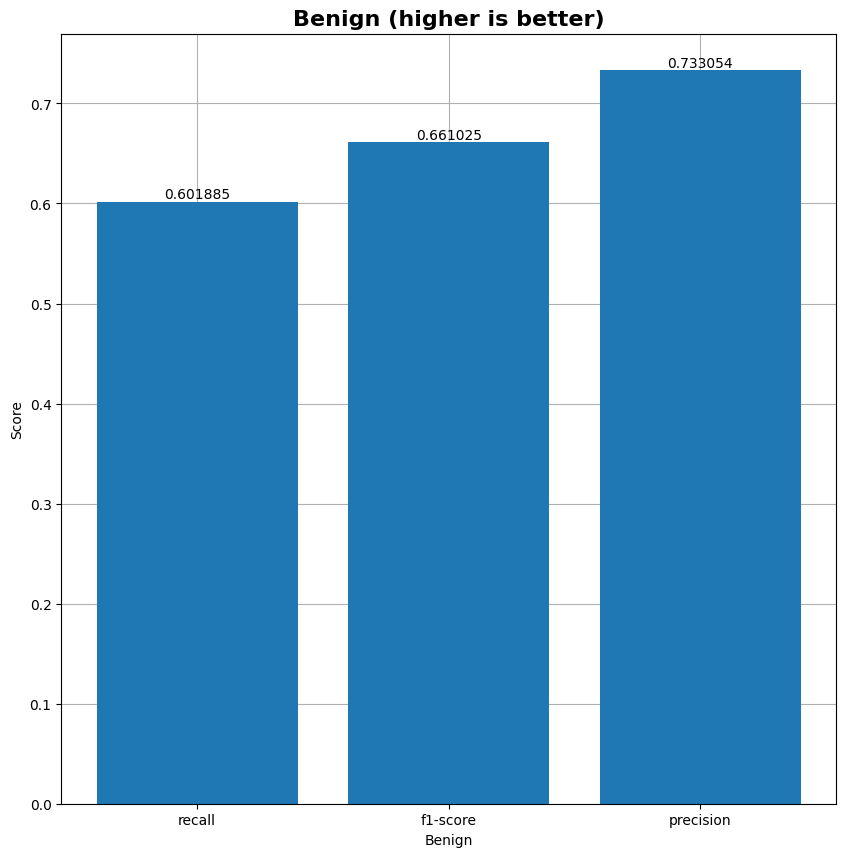

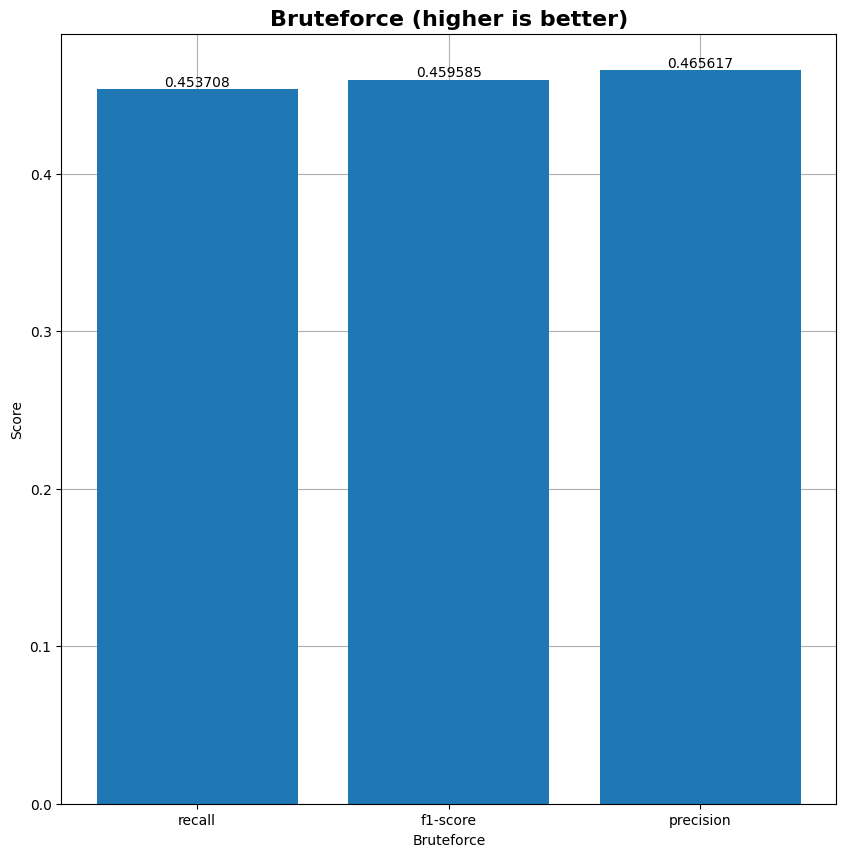

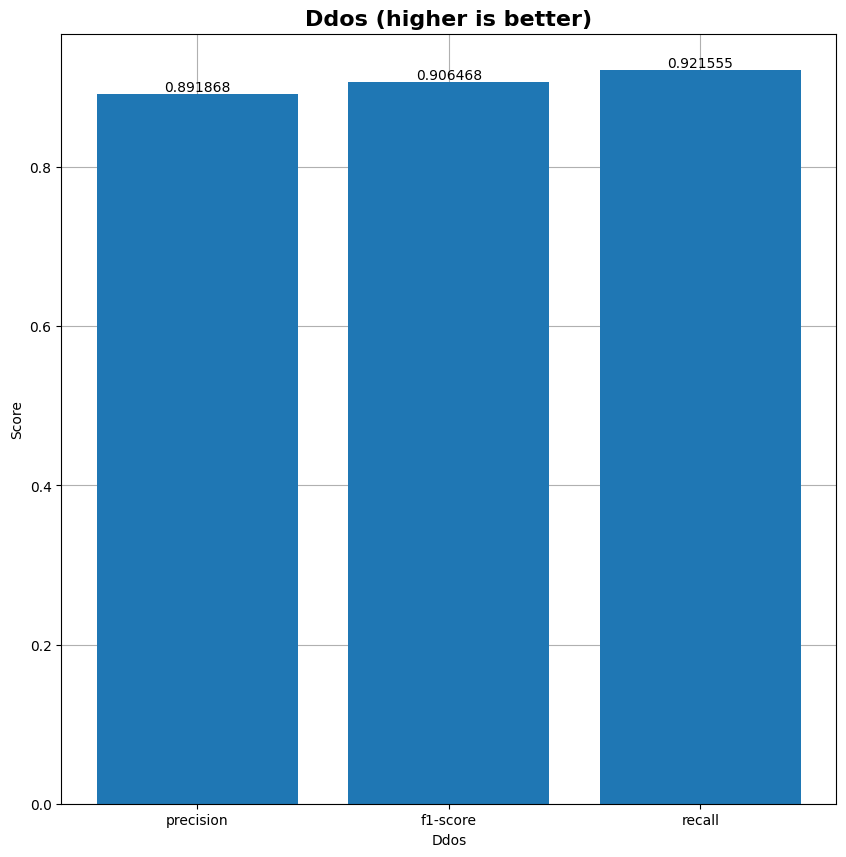

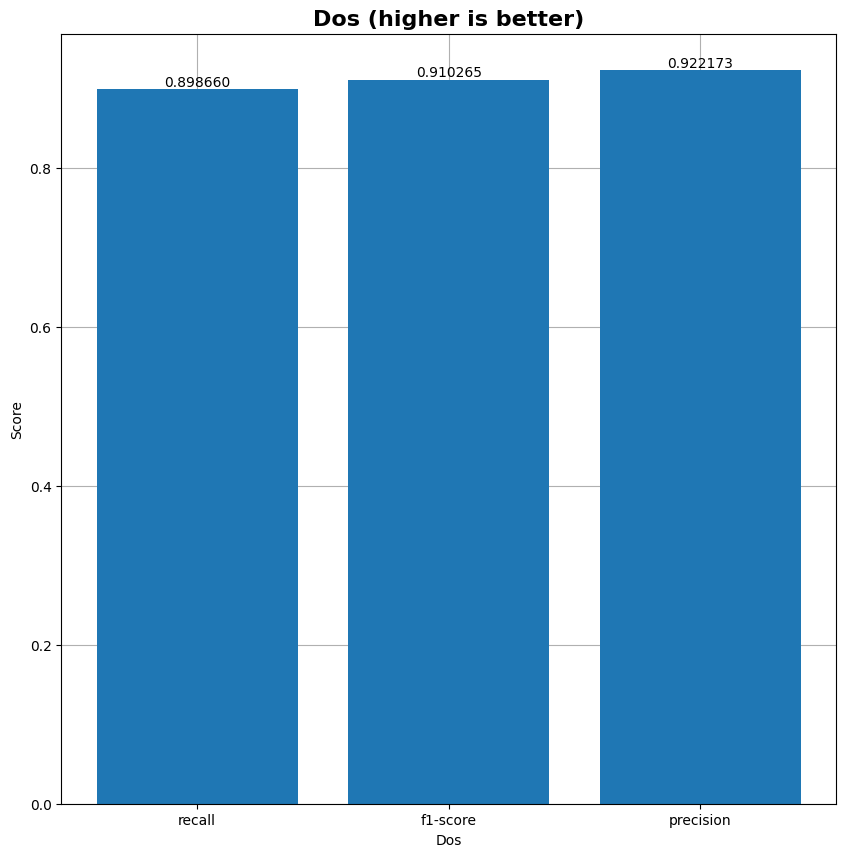

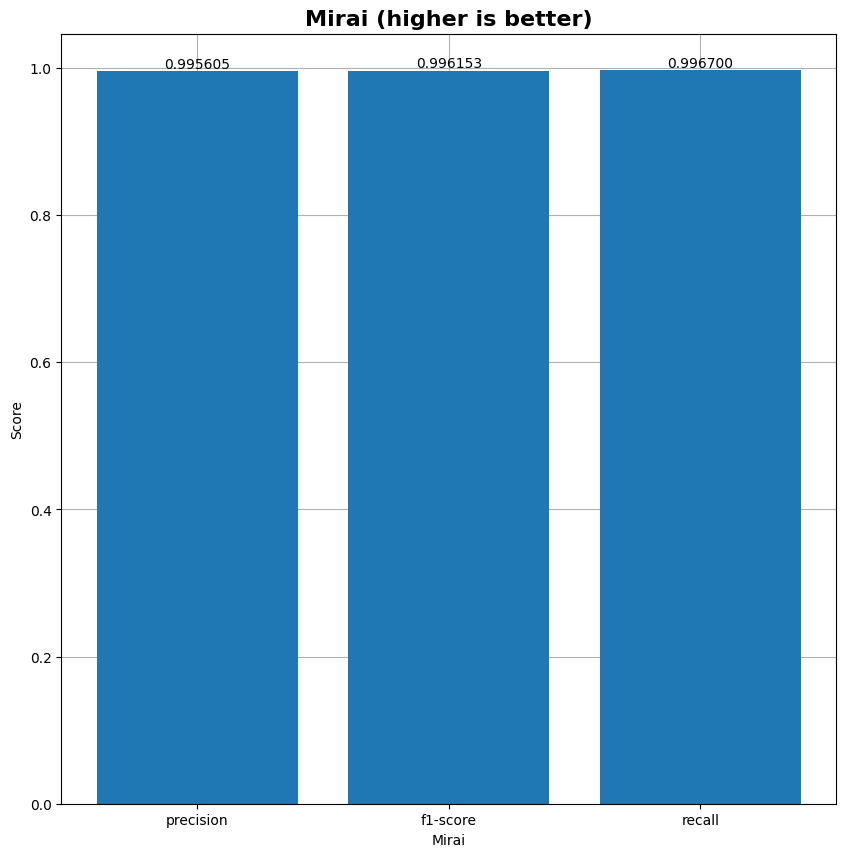

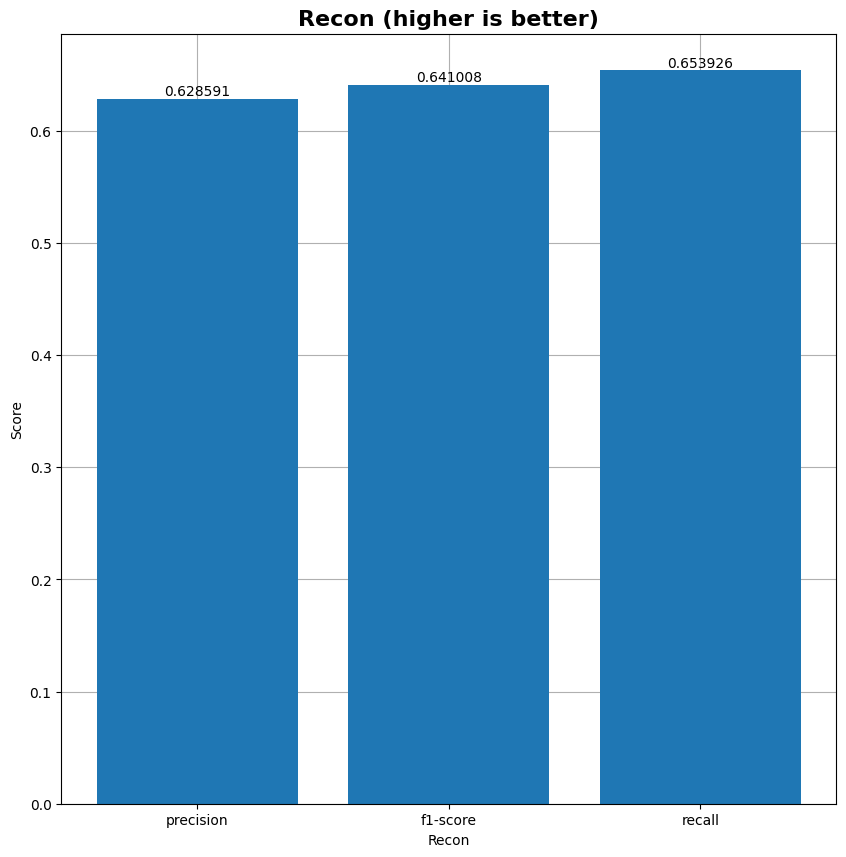

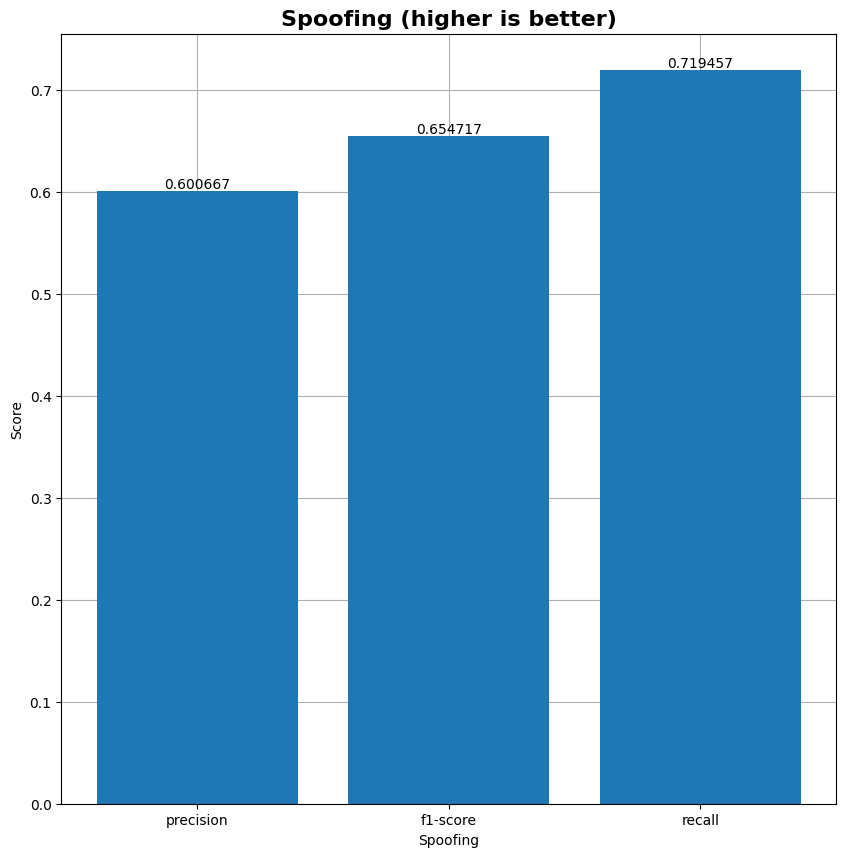

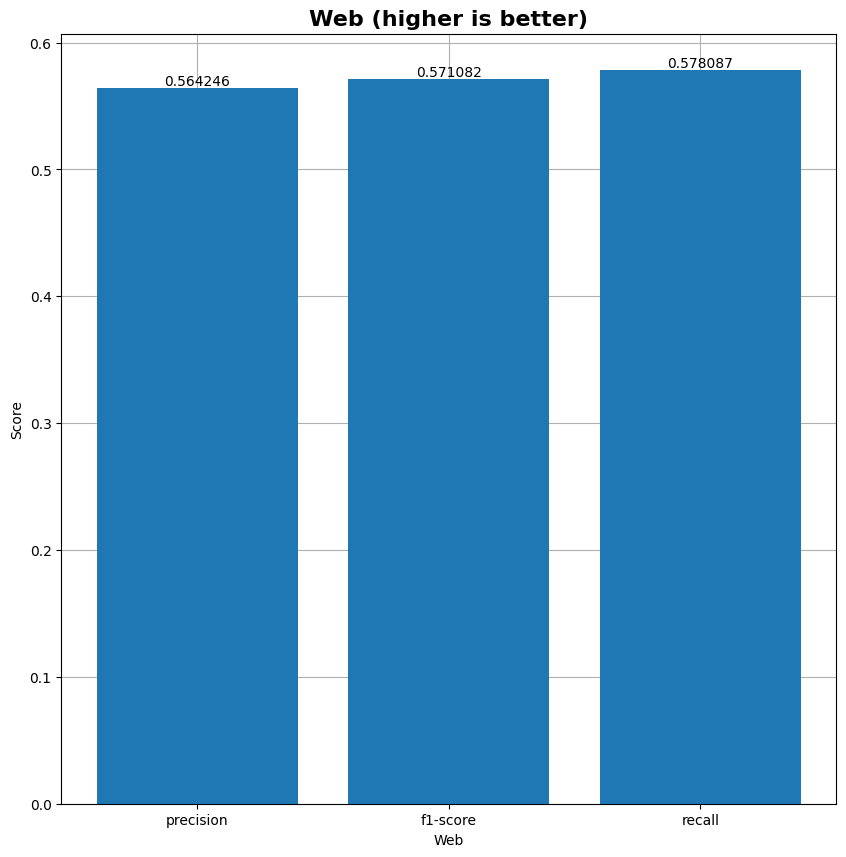

In [22]:
plot_mc(y_pred, y_test, "kNN")

In [23]:
model_name = "kNN_30000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Logistic Regression

In [24]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

CPU times: user 14min 44s, sys: 823 ms, total: 14min 45s
Wall time: 14min 46s


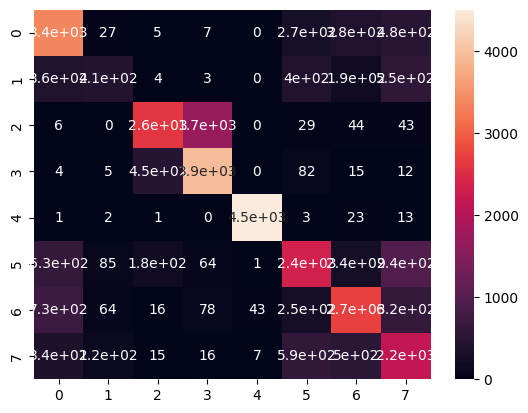

In [25]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [26]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [27]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LR_time]
results_dict["LR"] = results

In [28]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [29]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801
LR,0.674734,0.682499,0.667833,0.674734,0.627264,1.022090,4.822421,2.196001,886.337639


{'precision': {'Benign': 0.7440936189004195, 'Bruteforce': 0.2152230971128609, 'DDoS': 0.5875197116467673, 'DoS': 0.8749445676274945, 'Mirai': 0.990551527136893, 'Recon': 0.5237140948563794, 'Spoofing': 0.5988888888888889, 'Web': 0.575685022612397}, 'recall': {'Benign': 0.6192576258728408, 'Bruteforce': 0.5734265734265734, 'DDoS': 0.796092796092796, 'DoS': 0.6776575648291259, 'Mirai': 0.9888133362579513, 'Recon': 0.5914005531807895, 'Spoofing': 0.6608631682197156, 'Web': 0.44952222683838805}, 'f1-score': {'Benign': 0.6759602848259954, 'Bruteforce': 0.31297709923664124, 'DDoS': 0.6760855476344783, 'DoS': 0.7637665731152617, 'Mirai': 0.989681668496158, 'Recon': 0.5555030703826169, 'Spoofing': 0.6283515971088832, 'Web': 0.5048407791904818}}


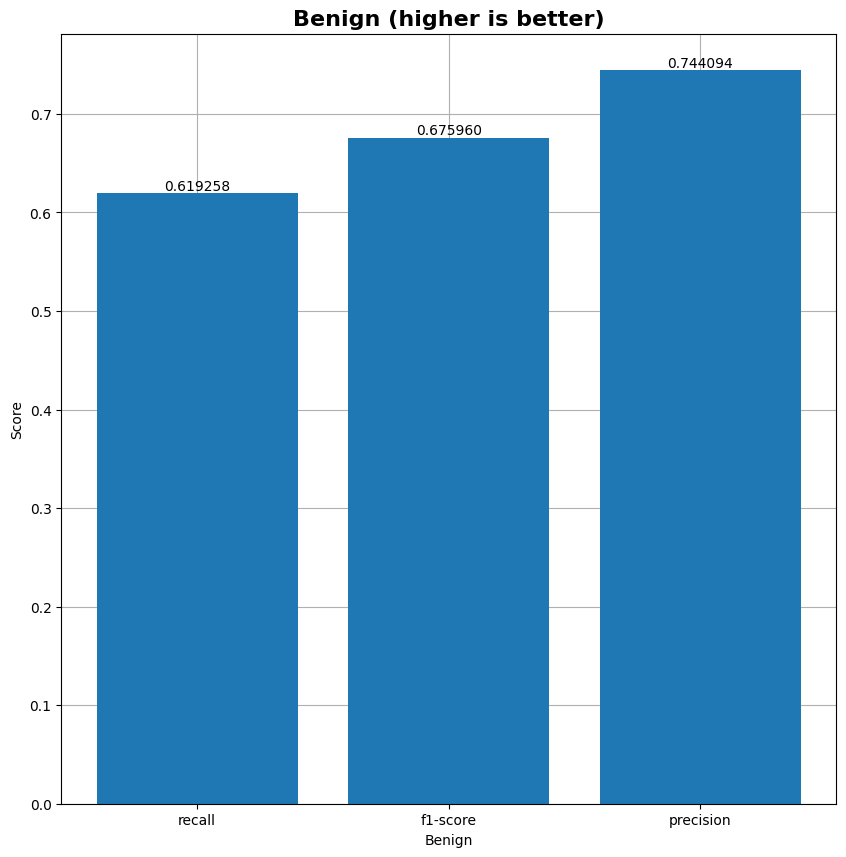

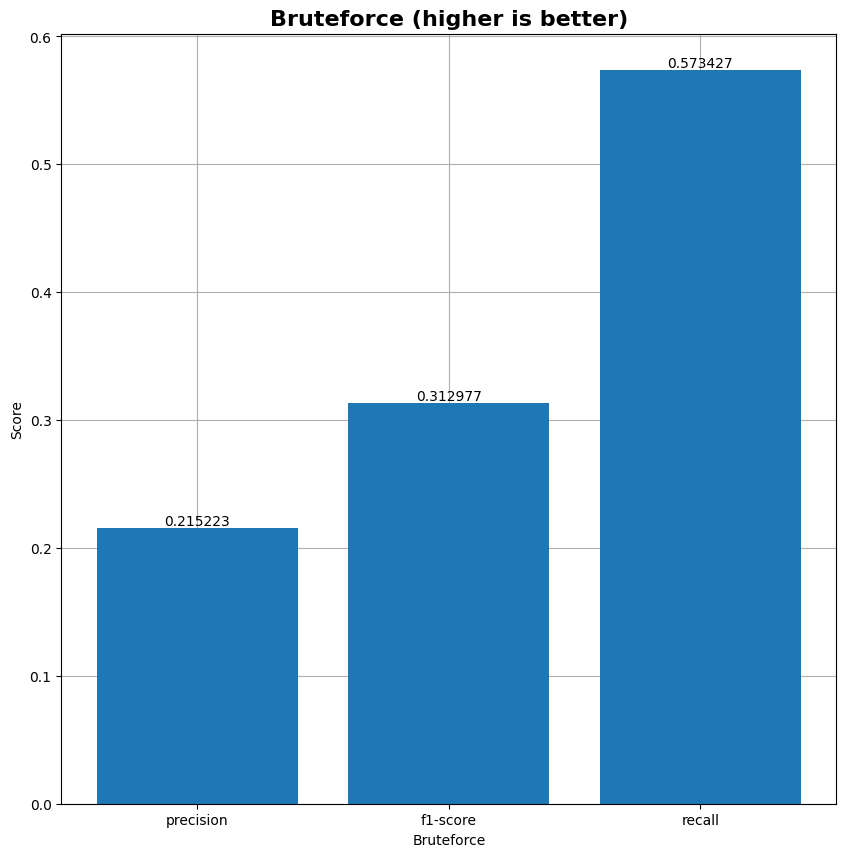

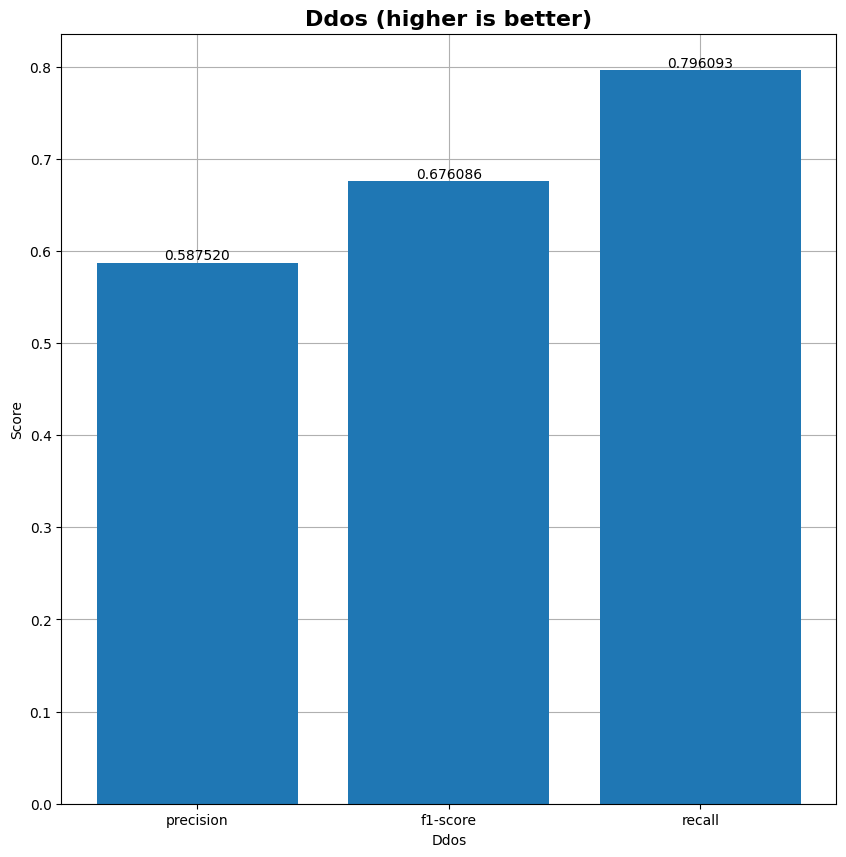

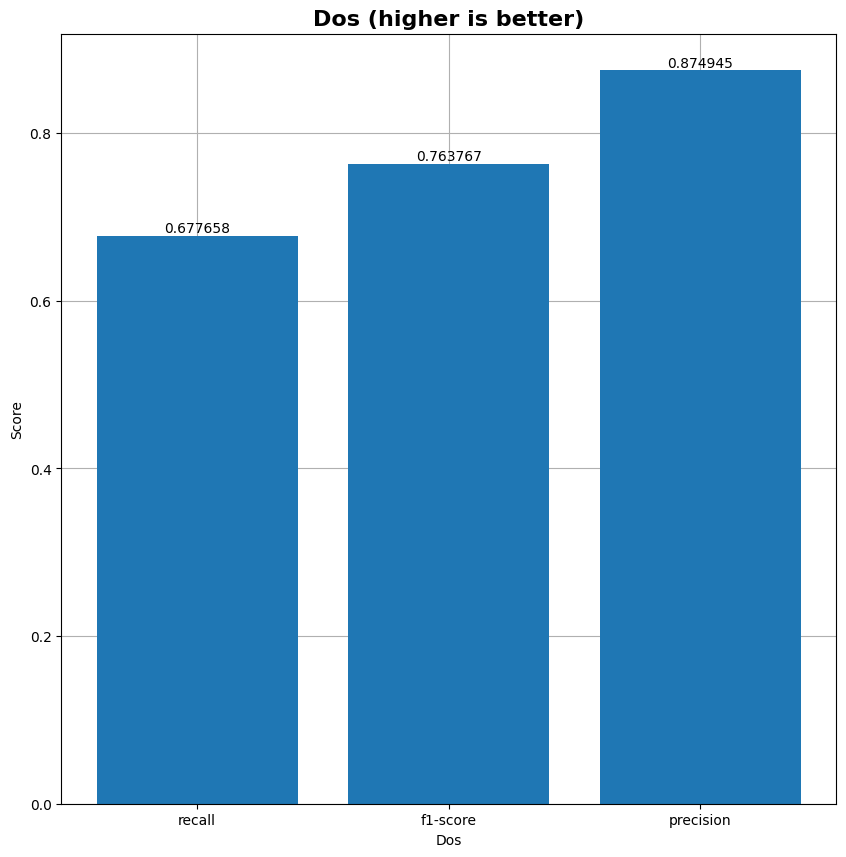

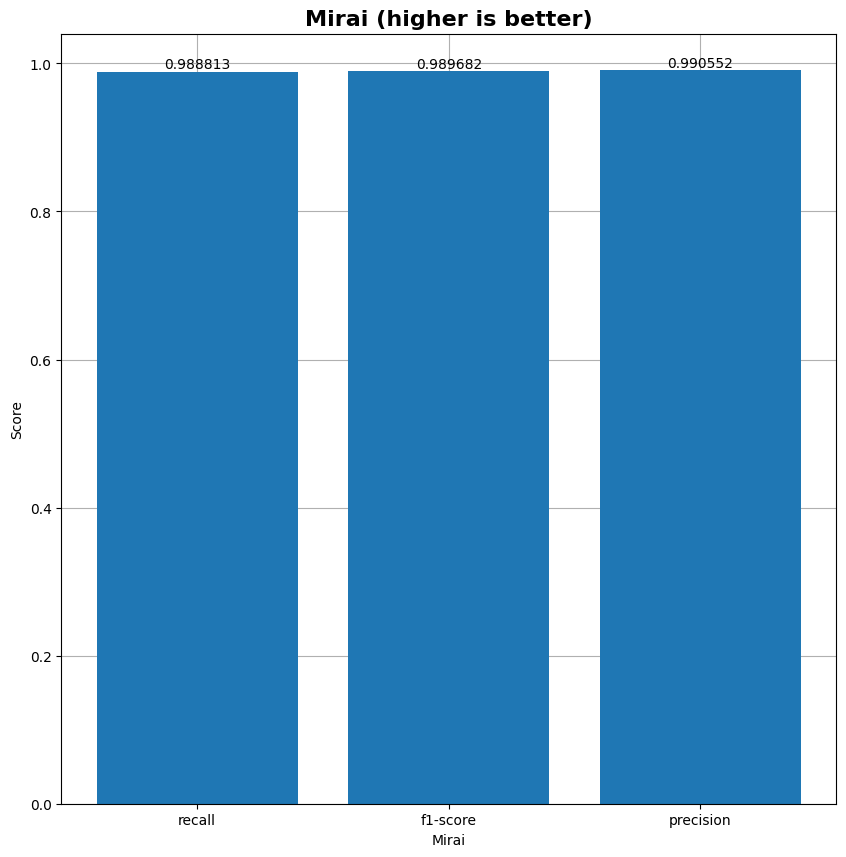

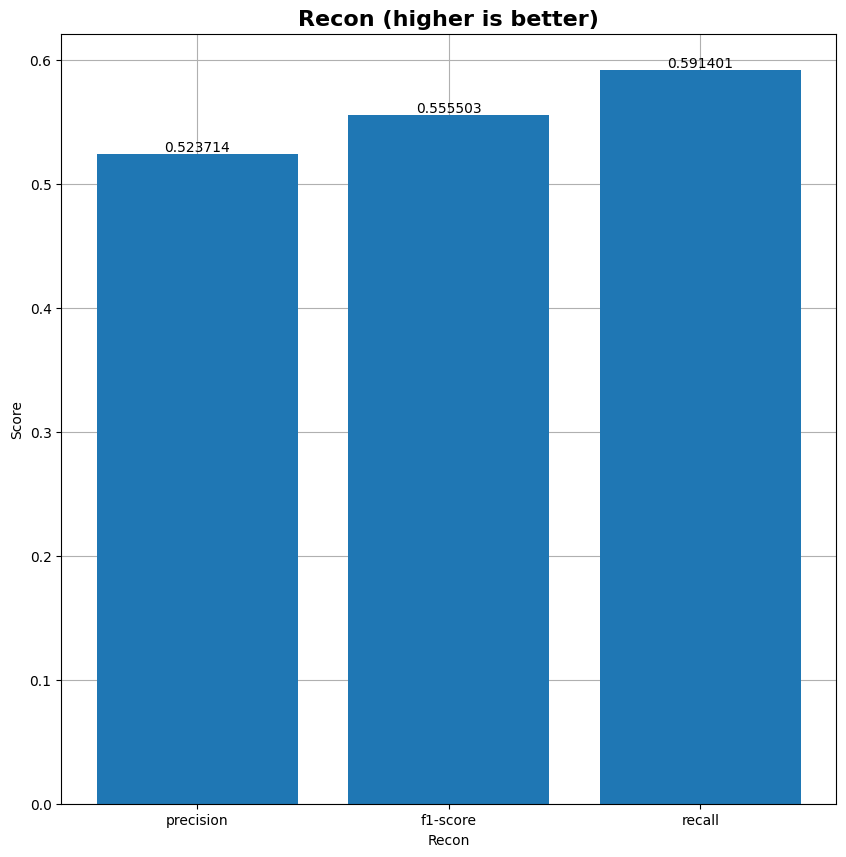

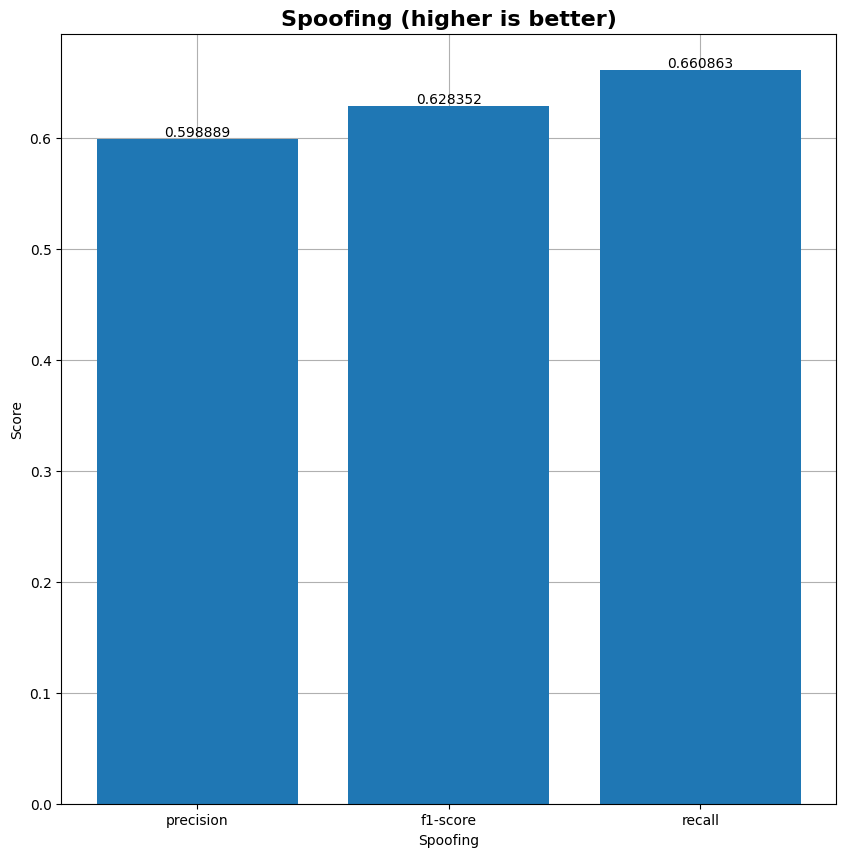

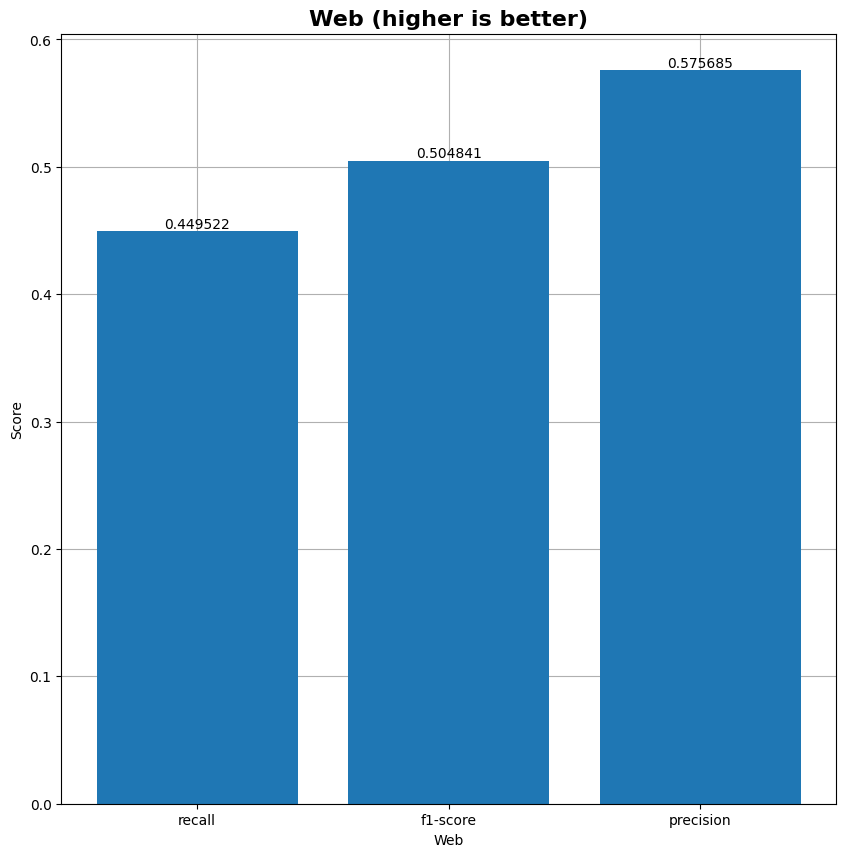

In [30]:
plot_mc(y_pred, y_test, "LR")

In [31]:
model_name = "LR_30000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [32]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 1min 20s, sys: 332 ms, total: 1min 20s
Wall time: 10.6 s


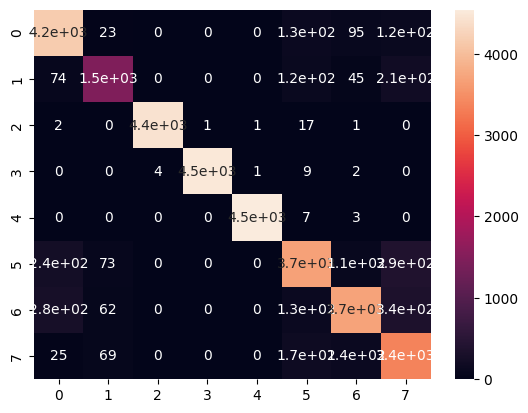

In [33]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [34]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [35]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [36]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [37]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801
LR,0.674734,0.682499,0.667833,0.674734,0.627264,1.022090,4.822421,2.196001,886.337639
RF,0.911975,0.914728,0.912087,0.911975,0.899128,0.308989,1.494401,1.222457,10.606501


{'precision': {'Benign': 0.9189666593066902, 'Bruteforce': 0.7637795275590551, 'DDoS': 0.9950439288127957, 'DoS': 0.9964523281596452, 'Mirai': 0.99780268072951, 'Recon': 0.820084613671788, 'Spoofing': 0.8204444444444444, 'Web': 0.8946528332003192}, 'recall': {'Benign': 0.8707112970711297, 'Bruteforce': 0.8650416171224733, 'DDoS': 0.9990952273241348, 'DoS': 0.9997775305895439, 'Mirai': 0.9995597622716267, 'Recon': 0.8643510912931237, 'Spoofing': 0.9049019607843137, 'Web': 0.7605156037991859}, 'f1-score': {'Benign': 0.8941884198087872, 'Bruteforce': 0.8112628937831057, 'DDoS': 0.9970654627539504, 'DoS': 0.9981121599111604, 'Mirai': 0.9986804486474599, 'Recon': 0.841636197440585, 'Spoofing': 0.8606060606060606, 'Web': 0.8221488815548221}}


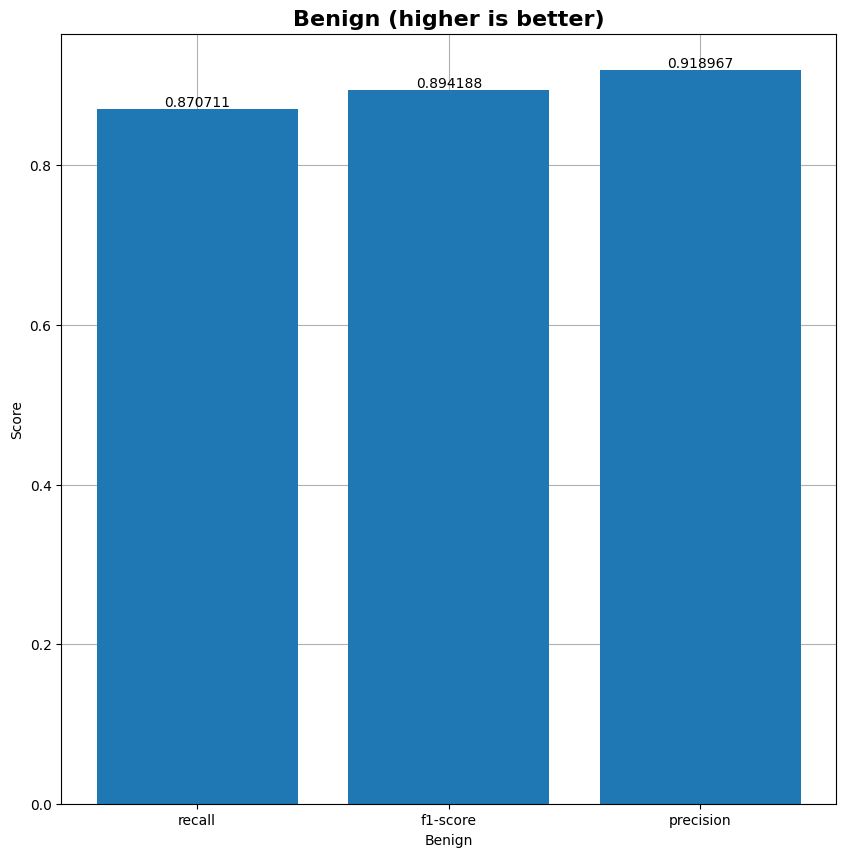

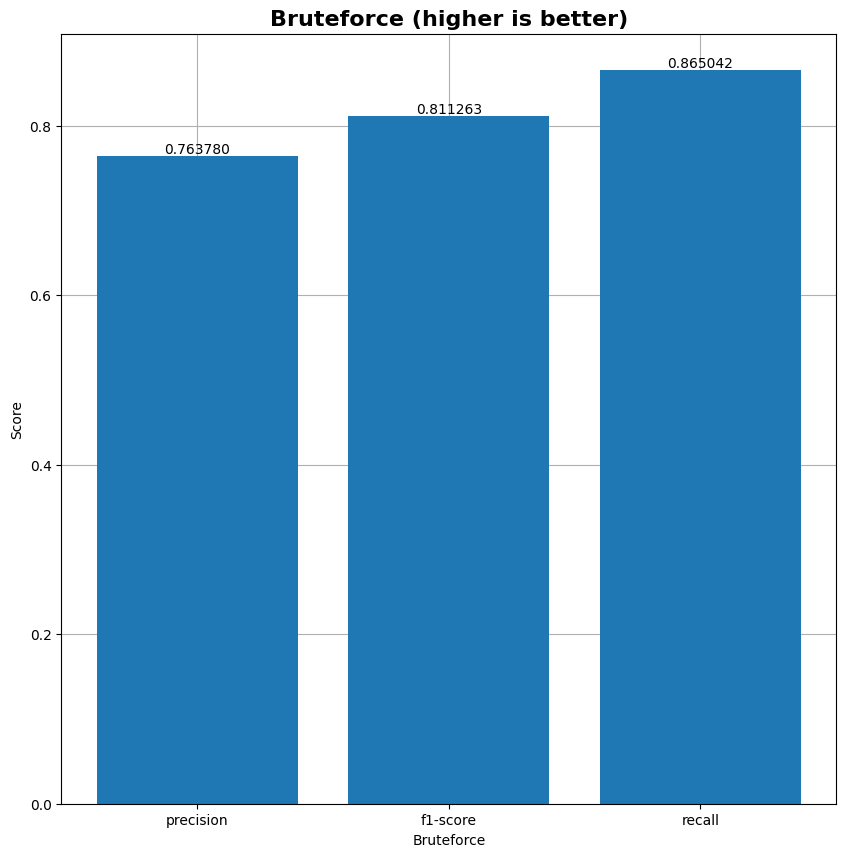

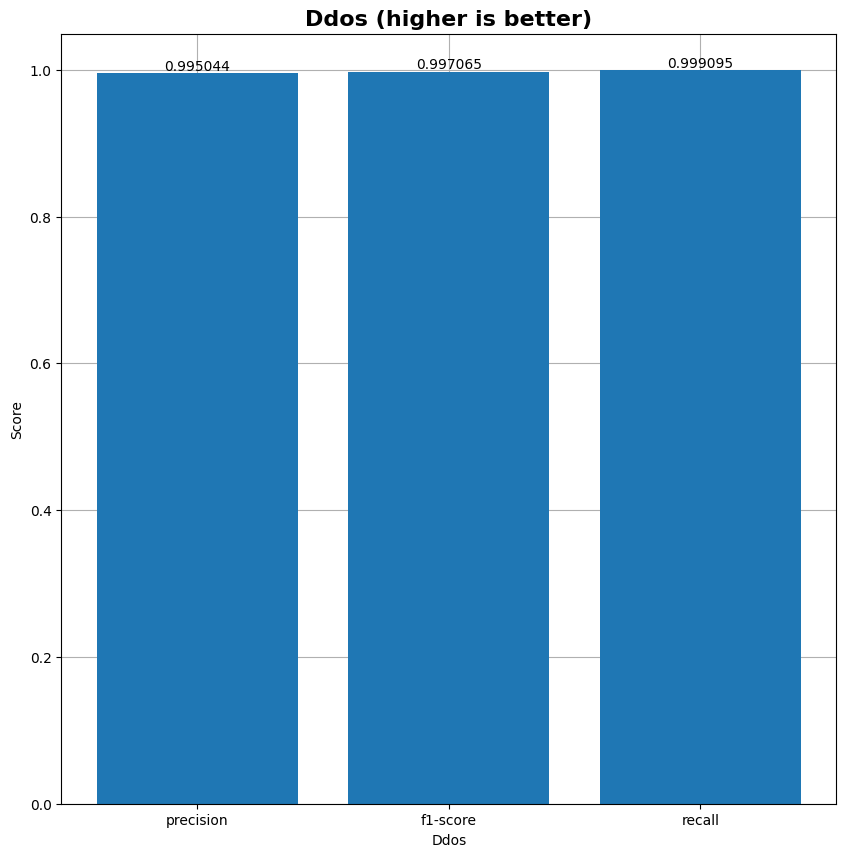

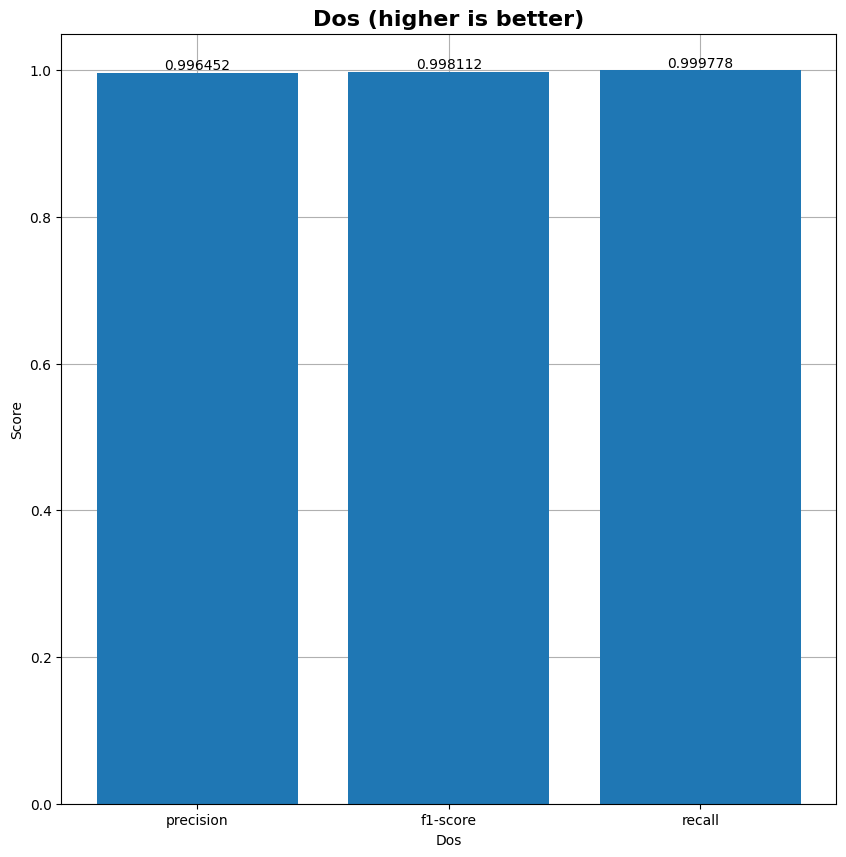

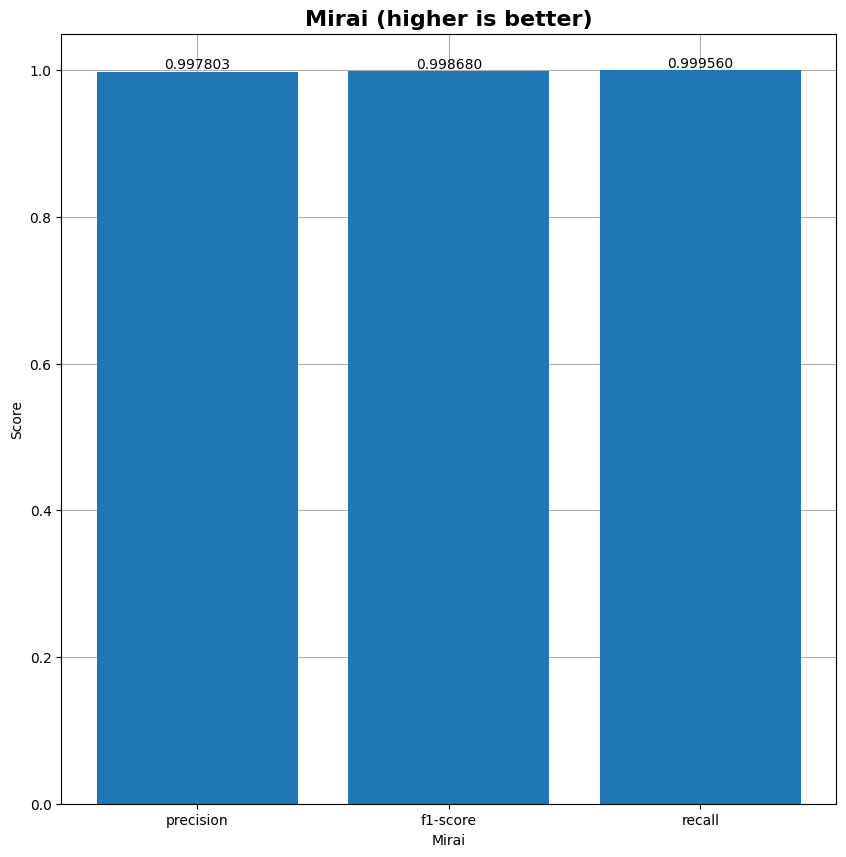

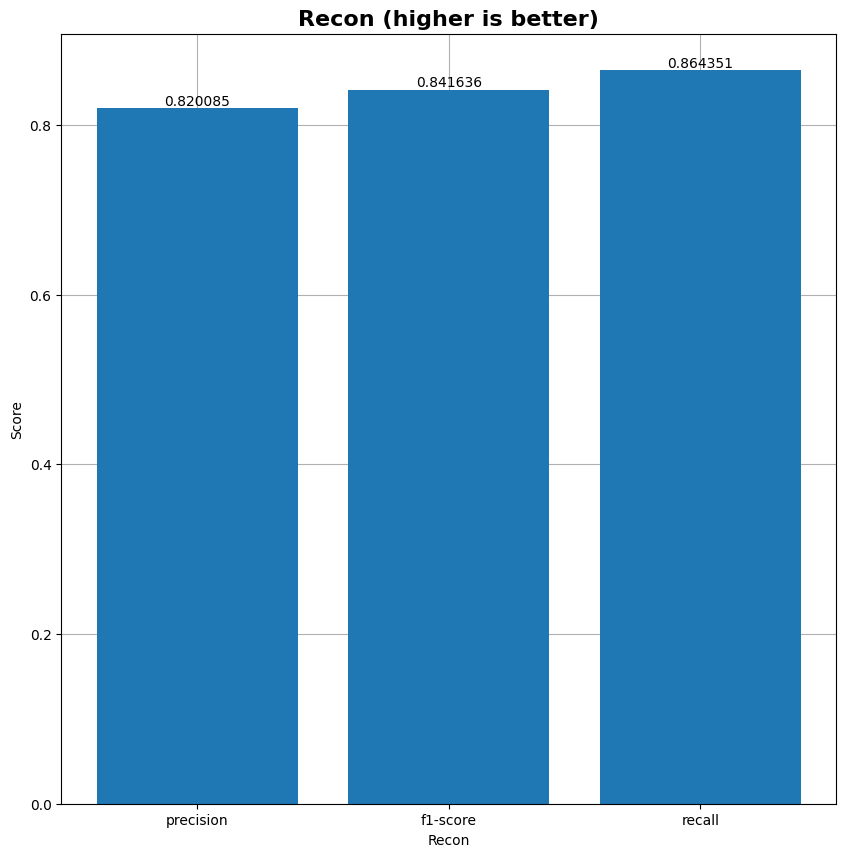

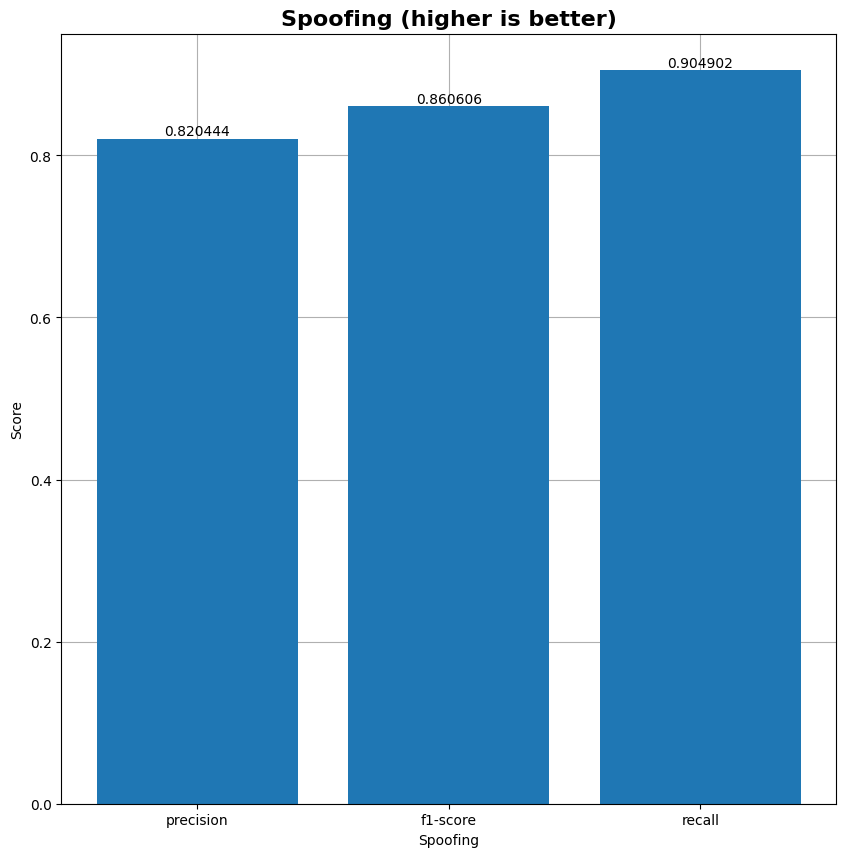

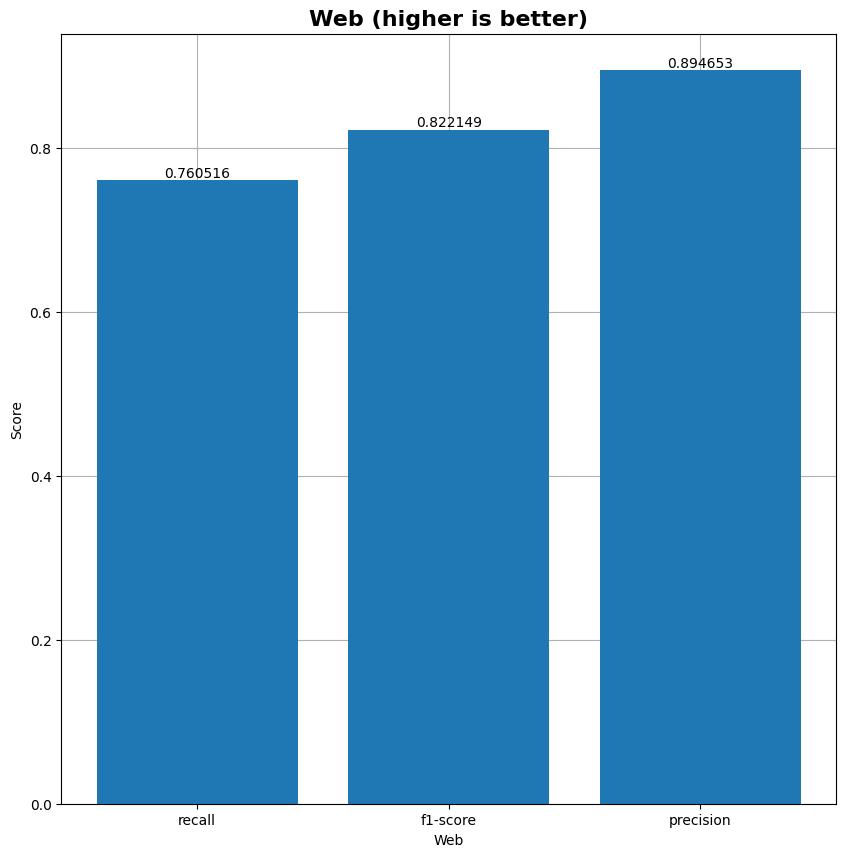

In [38]:
plot_mc(y_pred, y_test, "RF")

In [39]:
model_name = "RF_30000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [40]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 52.4 s, sys: 163 ms, total: 52.5 s
Wall time: 6.83 s


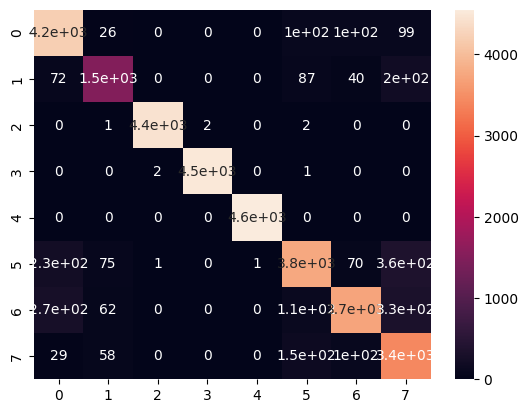

In [41]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [42]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [43]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [44]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [45]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801
LR,0.674734,0.682499,0.667833,0.674734,0.627264,1.022090,4.822421,2.196001,886.337639
RF,0.911975,0.914728,0.912087,0.911975,0.899128,0.308989,1.494401,1.222457,10.606501
XGBoost,0.921032,0.923801,0.921109,0.921032,0.909579,0.281973,1.377800,1.173797,6.829646


{'precision': {'Benign': 0.9277986310443807, 'Bruteforce': 0.7926509186351706, 'DDoS': 0.9988736201847263, 'DoS': 0.9993348115299335, 'Mirai': 1.0, 'Recon': 0.8356713426853707, 'Spoofing': 0.8277777777777777, 'Web': 0.9100824687416866}, 'recall': {'Benign': 0.8748698729960441, 'Bruteforce': 0.871824480369515, 'DDoS': 0.9993238674780257, 'DoS': 0.9995564426702152, 'Mirai': 0.999780316344464, 'Recon': 0.8925089179548157, 'Spoofing': 0.9222579846496658, 'Web': 0.7762650329022011}, 'f1-score': {'Benign': 0.9005572224603515, 'Bruteforce': 0.8303546879296123, 'DDoS': 0.9990986931050022, 'DoS': 0.9994456148131722, 'Mirai': 0.9998901461056795, 'Recon': 0.8631554737810487, 'Spoofing': 0.8724675020494203, 'Web': 0.8378643154543228}}


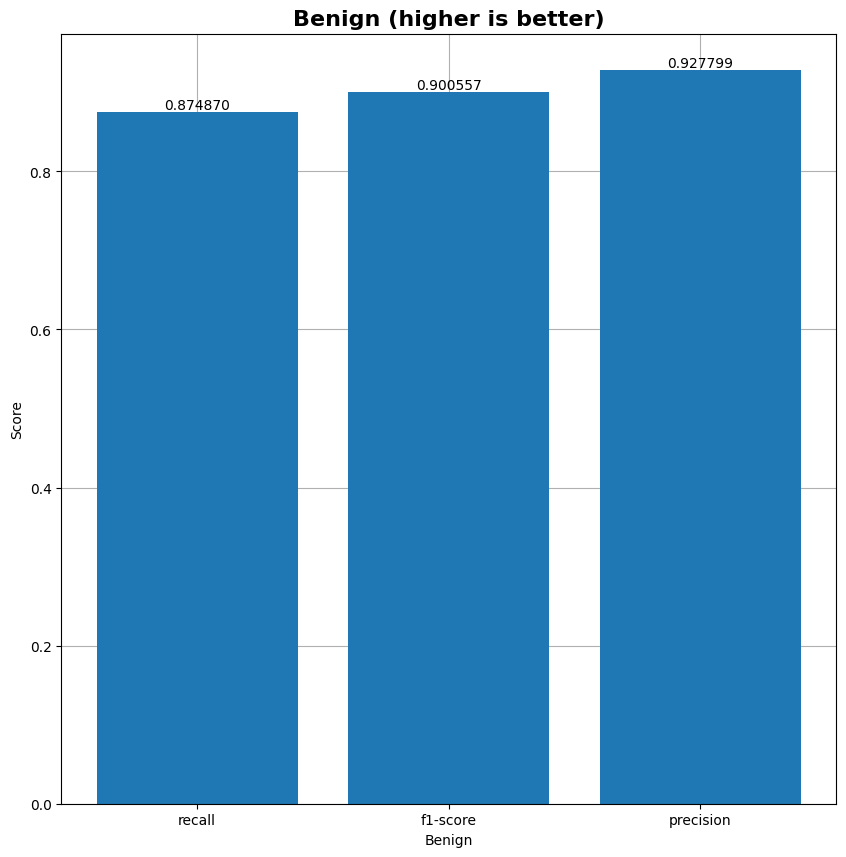

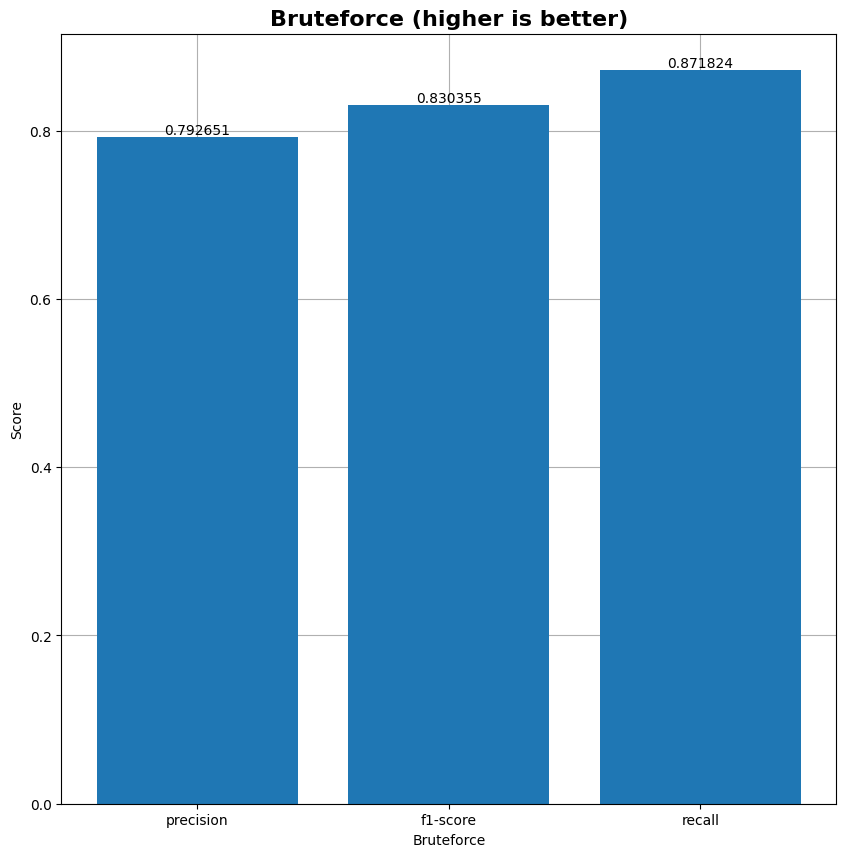

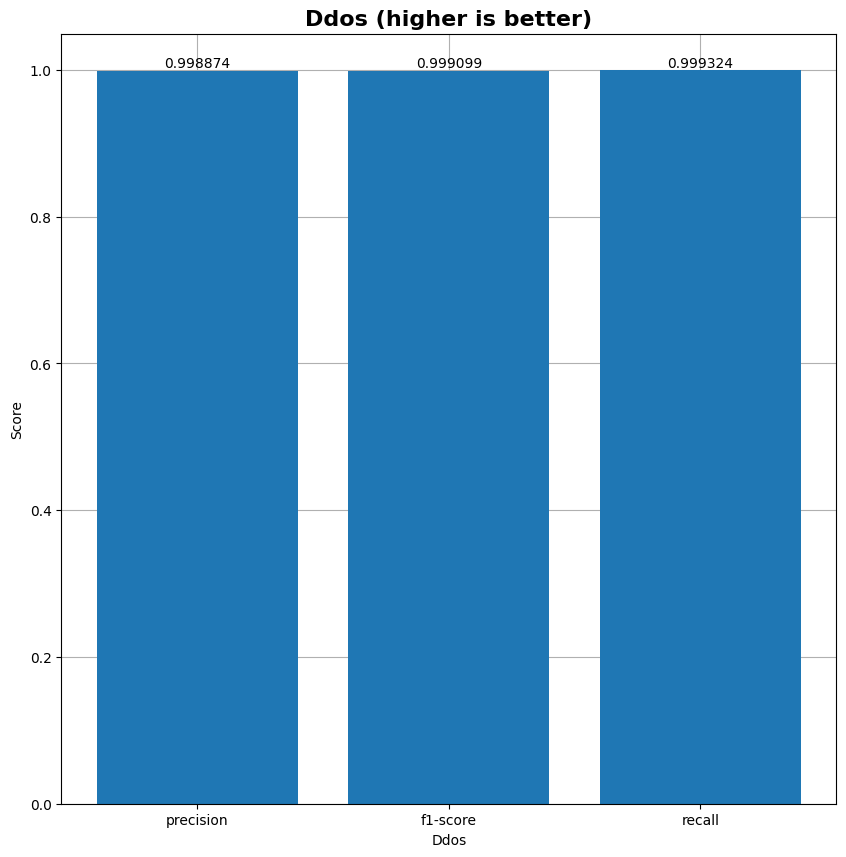

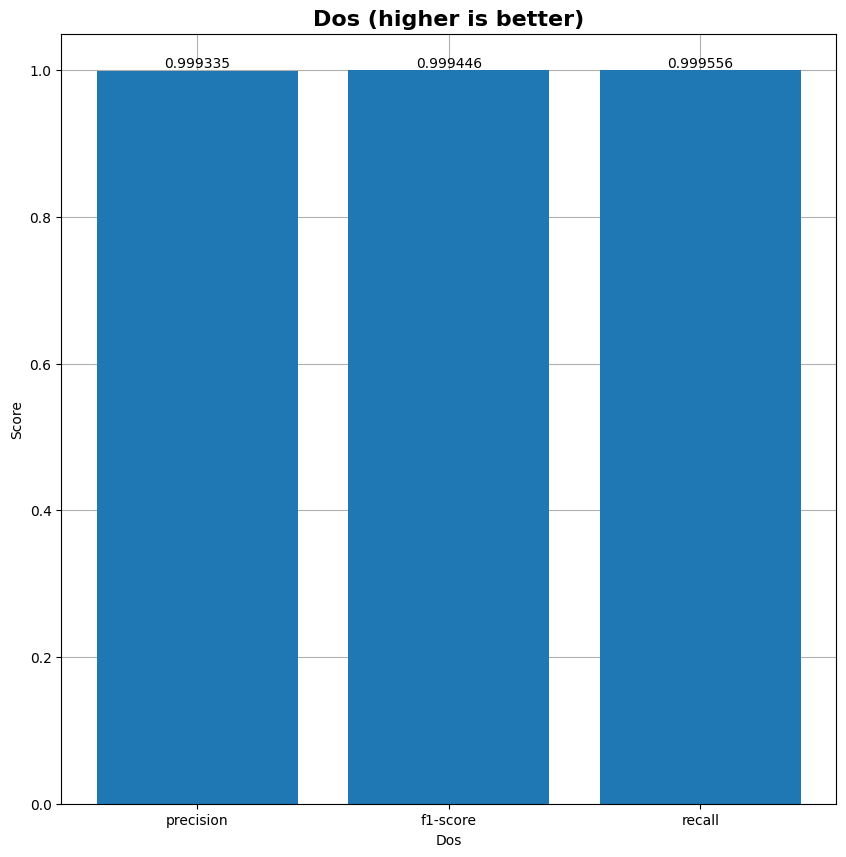

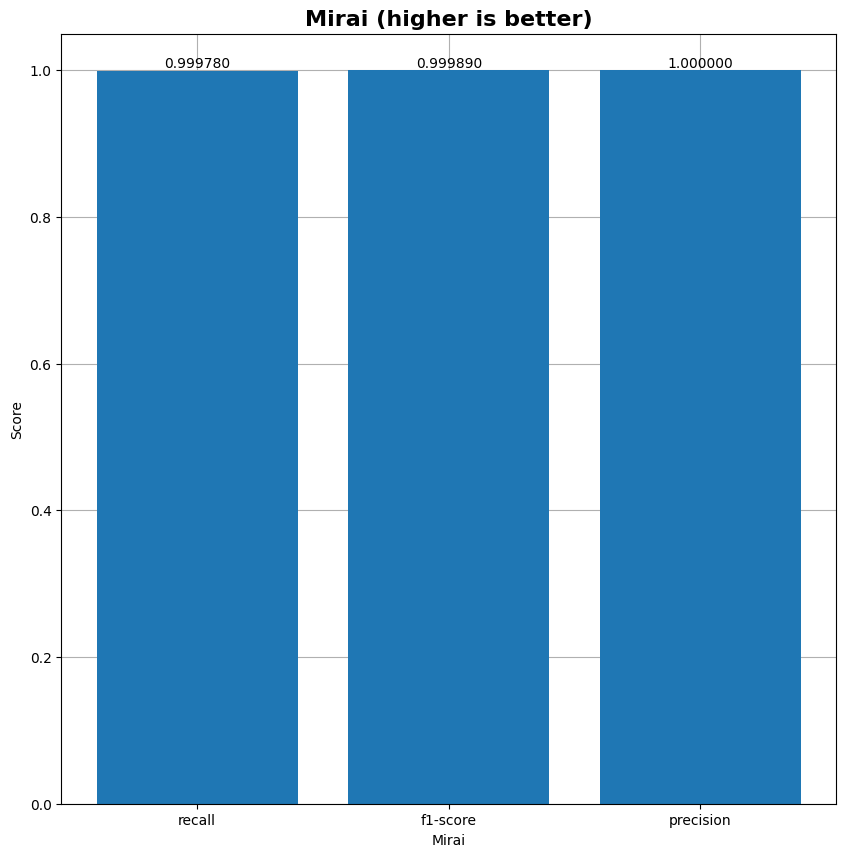

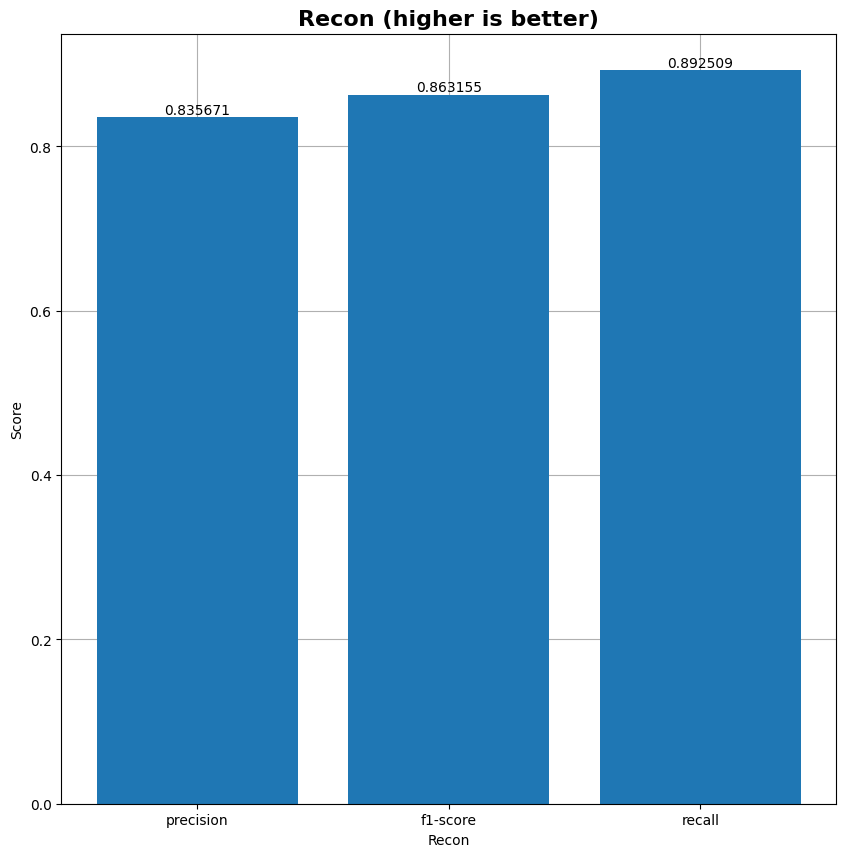

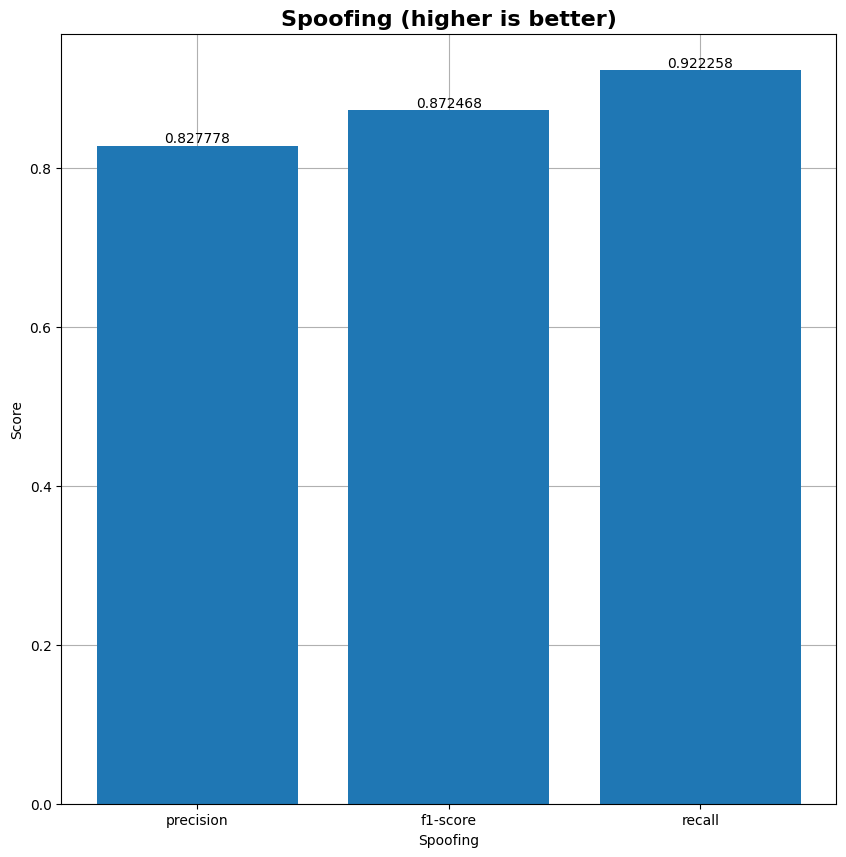

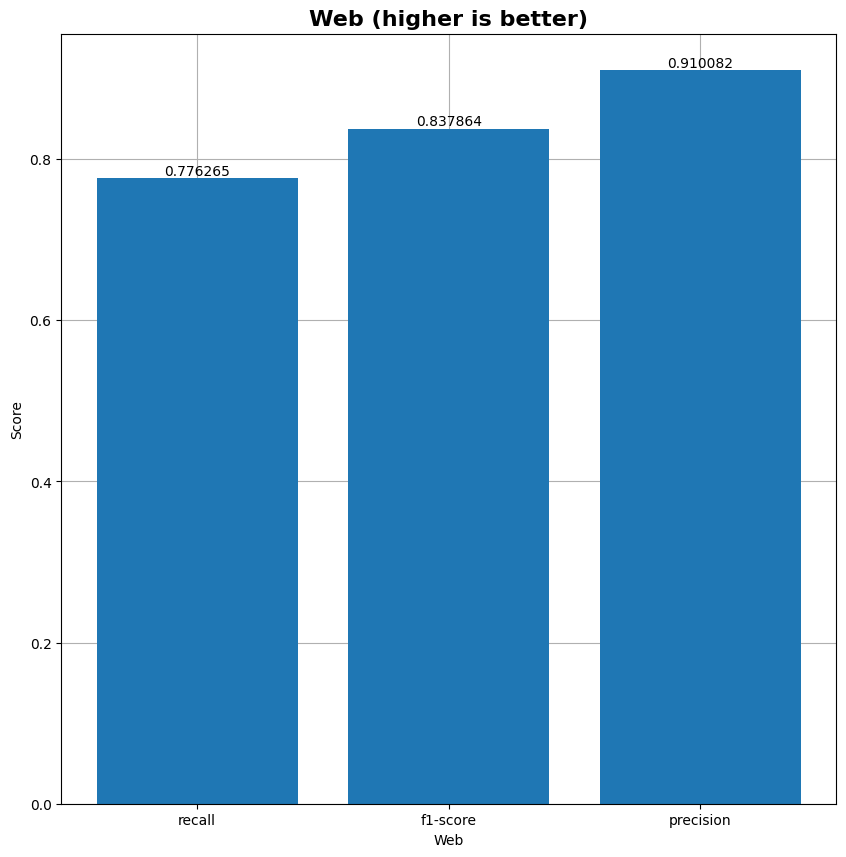

In [46]:
plot_mc(y_pred, y_test, "XGBoost")

In [47]:
model_name = "XGB_30000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [48]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5350
[LightGBM] [Info] Number of data points in the train set: 185209, number of used features: 39
[LightGBM] [Info] Start training from score -1.983944
[LightGBM] [Info] Start training from score -2.809239
[LightGBM] [Info] Start training from score -1.980417
[LightGBM] [Info] Start training from score -1.983199
[LightGBM] [Info] Start training from score -1.984808
[LightGBM] [Info] Start training from score -1.982454
[LightGBM] [Info] Start training from score -1.982806
[LightGBM] [Info] Start training from score -2.173635


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 22 s, sys: 109 ms, total: 22.1 s
Wall time: 5.65 s


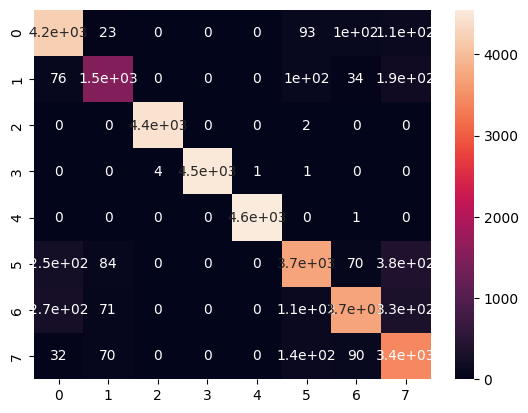

In [49]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [50]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [51]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [52]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [53]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801
LR,0.674734,0.682499,0.667833,0.674734,0.627264,1.022090,4.822421,2.196001,886.337639
RF,0.911975,0.914728,0.912087,0.911975,0.899128,0.308989,1.494401,1.222457,10.606501
XGBoost,0.921032,0.923801,0.921109,0.921032,0.909579,0.281973,1.377800,1.173797,6.829646
LightGBM,0.919532,0.922554,0.919607,0.919532,0.907907,0.291182,1.429354,1.195556,5.649458


{'precision': {'Benign': 0.9275778317509384, 'Bruteforce': 0.7889763779527559, 'DDoS': 0.9995494480738906, 'DoS': 0.998669623059867, 'Mirai': 0.999780268072951, 'Recon': 0.8274326430639056, 'Spoofing': 0.8255555555555556, 'Web': 0.9119446661346102}, 'recall': {'Benign': 0.8699523710913233, 'Bruteforce': 0.8583666476299258, 'DDoS': 0.9990993019590182, 'DoS': 1.0, 'Mirai': 0.999780268072951, 'Recon': 0.8934840105794662, 'Spoofing': 0.925280199252802, 'Web': 0.7731168245376635}, 'f1-score': {'Benign': 0.8978414191066467, 'Bruteforce': 0.8222100656455142, 'DDoS': 0.9993243243243243, 'DoS': 0.9993343687597072, 'Mirai': 0.999780268072951, 'Recon': 0.8591907514450867, 'Spoofing': 0.8725778038755138, 'Web': 0.8368119126083242}}


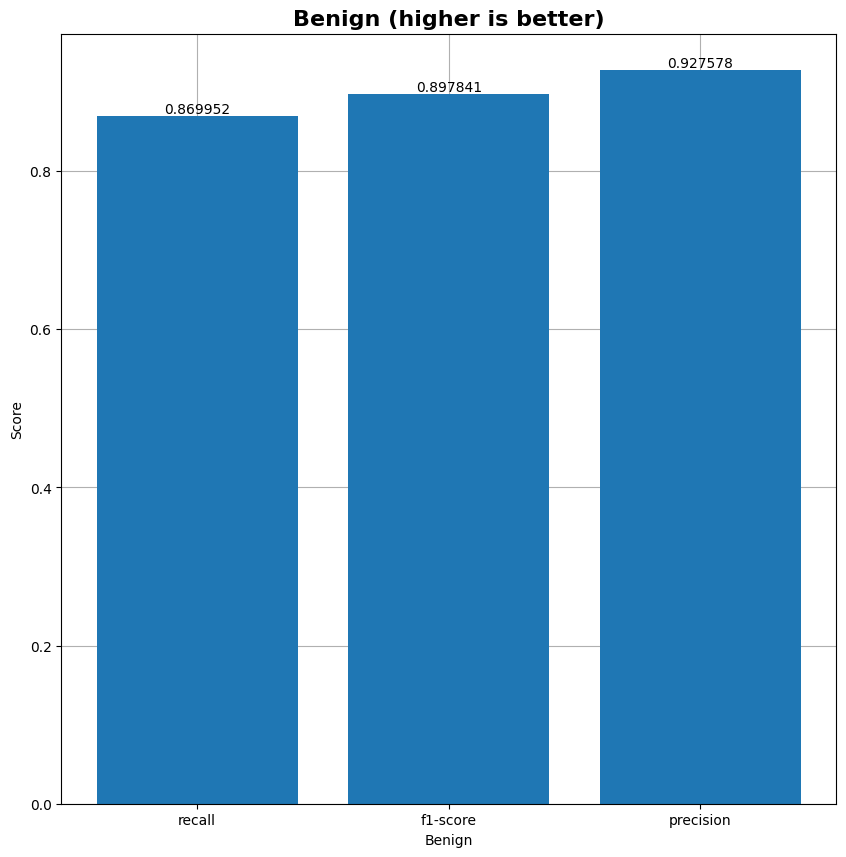

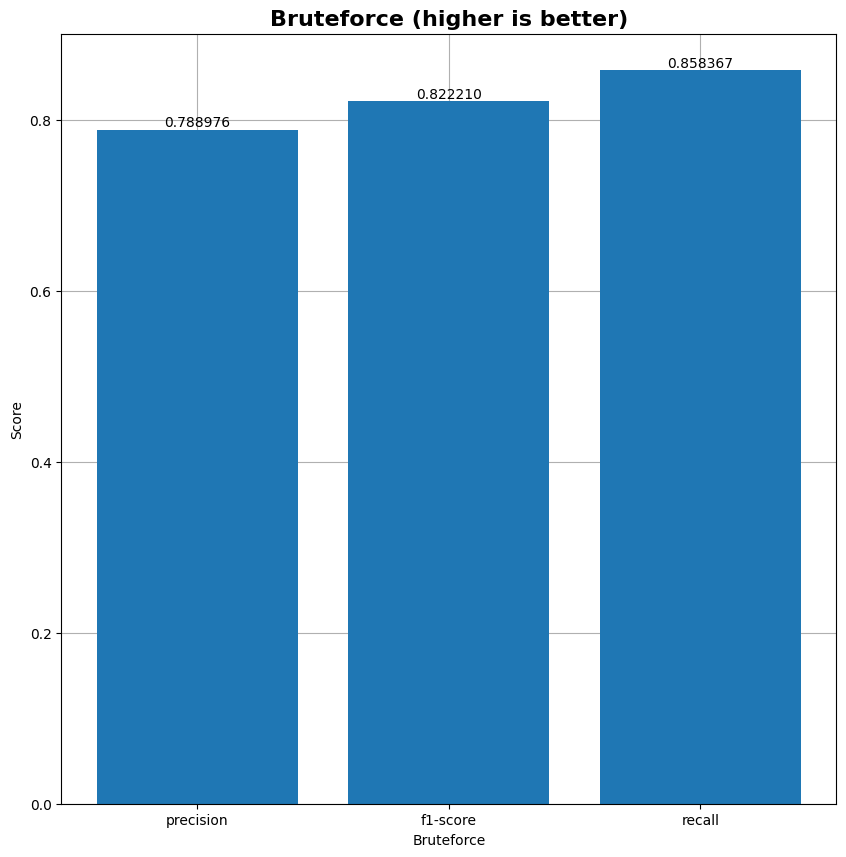

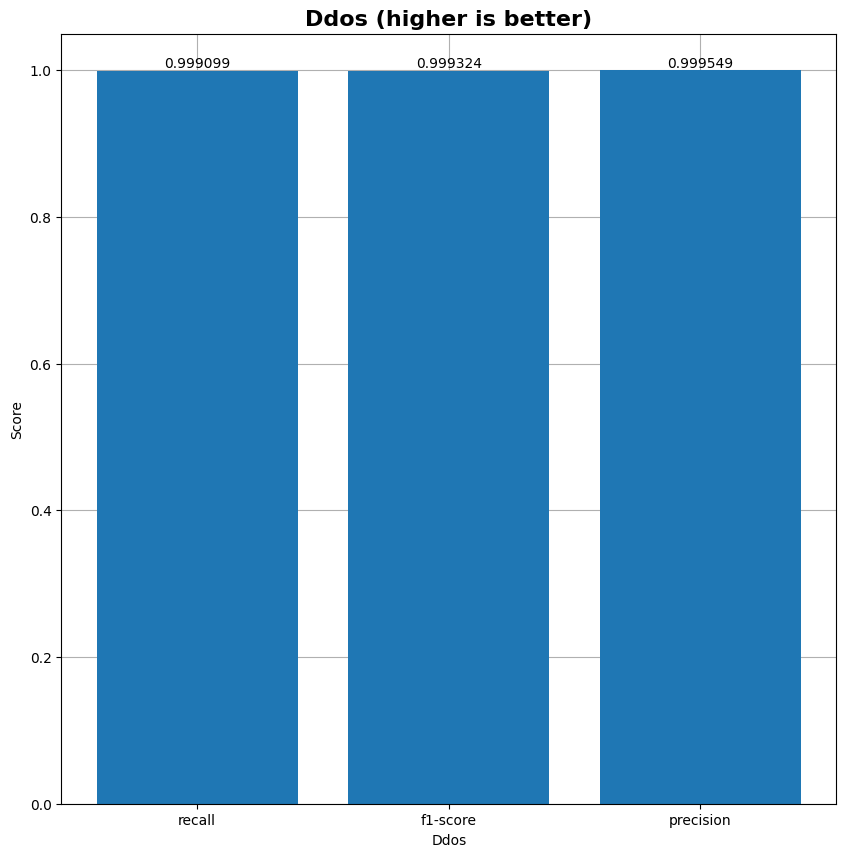

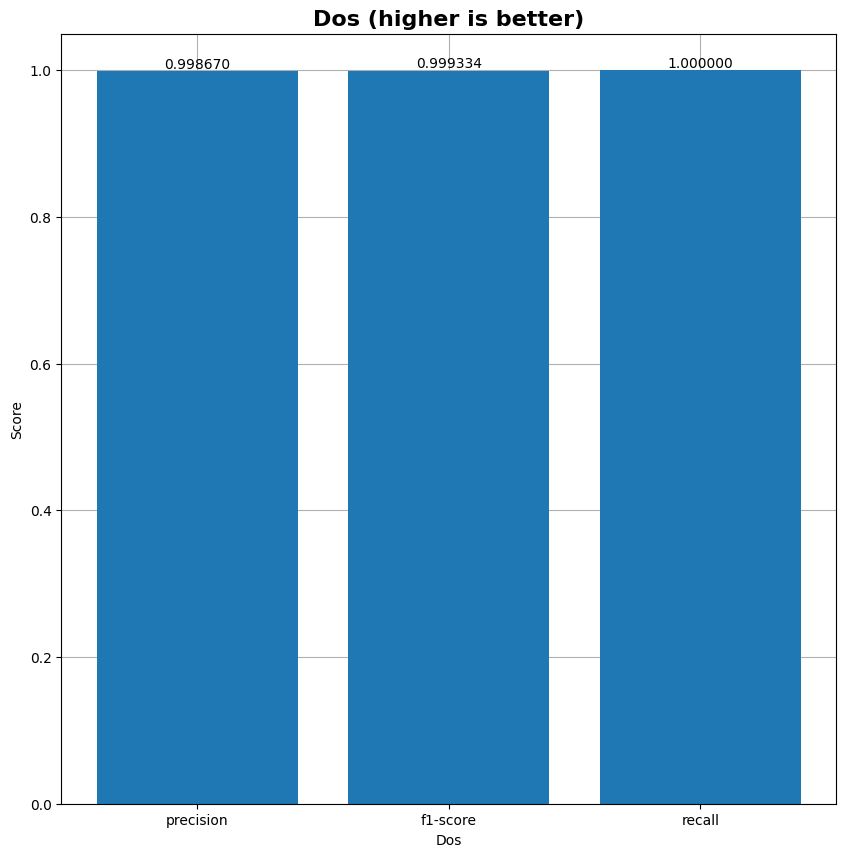

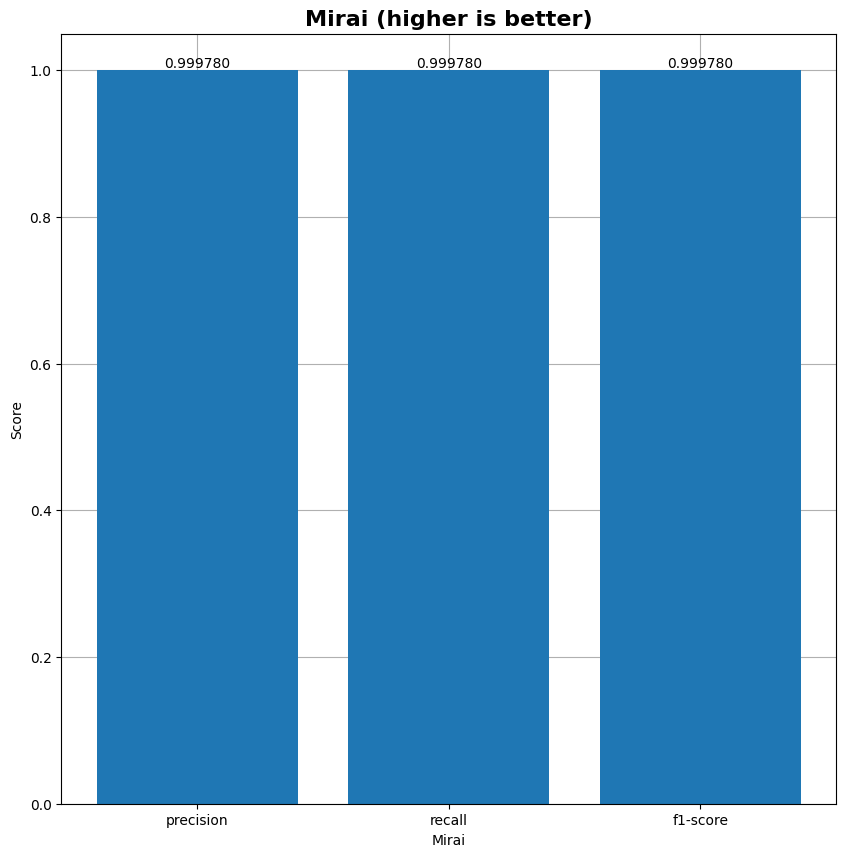

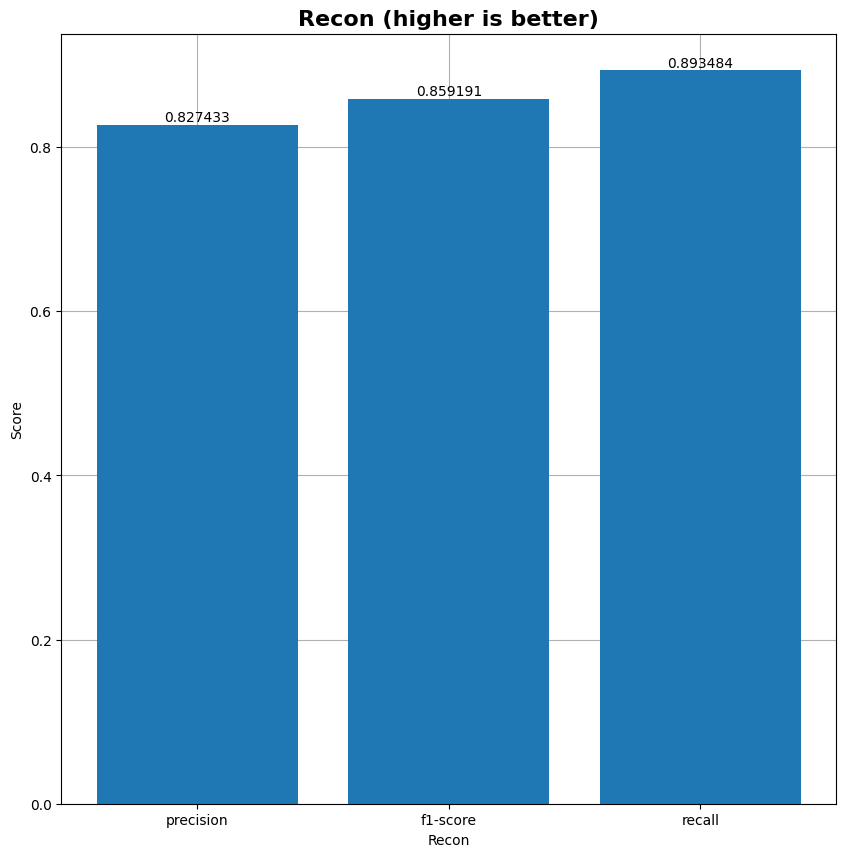

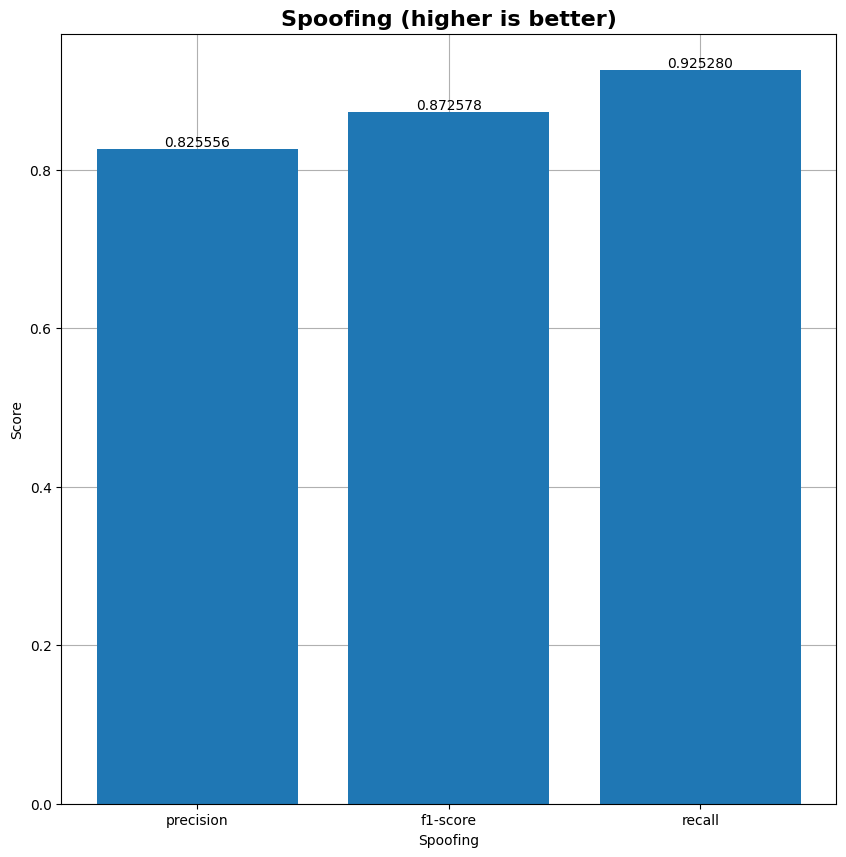

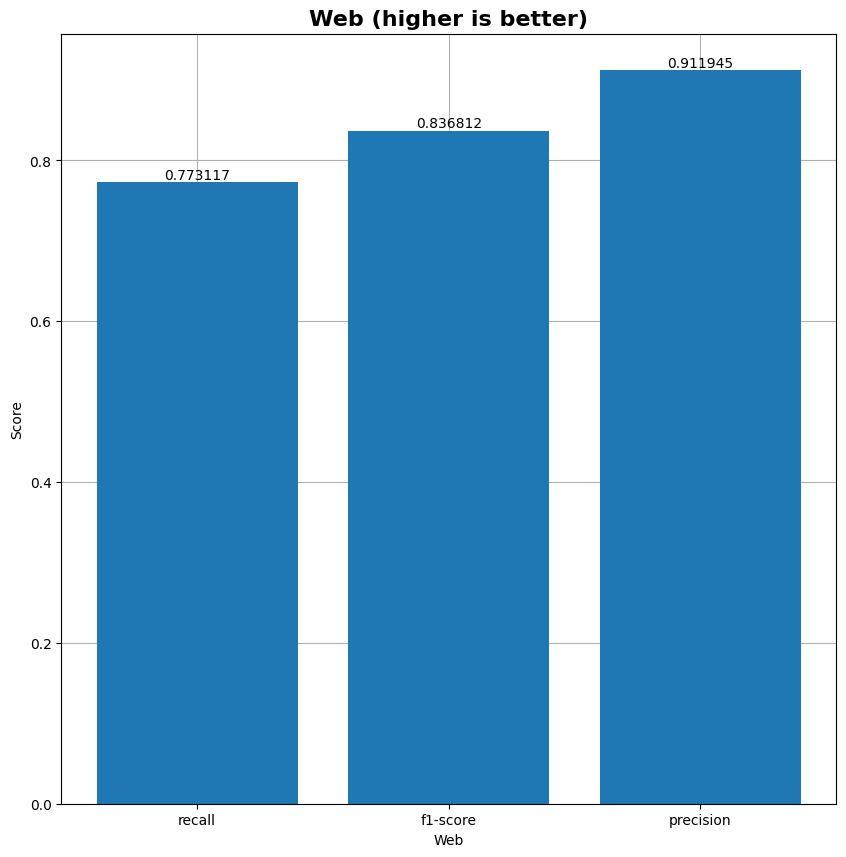

In [54]:
plot_mc(y_pred, y_test, "LightGBM")

In [55]:
model_name = "LightGBM_30000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((151871, 46), (151871,), (33338, 46), (33338,), (32684, 46), (32684,))

In [57]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744737629.525800   99095 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5141 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744737631.205553  115216 service.cc:152] XLA service 0x7203d800b800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744737631.205567  115216 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-15 20:20:31.246130: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744737631.426162  115216 cuda_dnn.cc:529] Loaded cuDNN version 90300


  83/9492 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.5018 - loss: 1.4355       

I0000 00:00:1744737632.358930  115216 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9492/9492 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.6742 - loss: 0.7874 - val_accuracy: 0.7279 - val_loss: 0.6488
Epoch 2/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7328 - loss: 0.6409 - val_accuracy: 0.7426 - val_loss: 0.6219
Epoch 3/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7440 - loss: 0.6150 - val_accuracy: 0.7461 - val_loss: 0.6055
Epoch 4/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7527 - loss: 0.5923 - val_accuracy: 0.7589 - val_loss: 0.5836
Epoch 5/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7571 - loss: 0.5802 - val_accuracy: 0.7613 - val_loss: 0.5770
Epoch 6/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7621 - loss: 0.5711 - val_accuracy: 0.7622 - val_loss: 0.5823
Epoch 7/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7643 - loss: 0.5670 - val_accuracy: 0.7602 - val_loss: 0.5719
Epoch 8/20
9492/9492 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7683 - loss: 0.5617 - val

In [60]:
y_pred = np.argmax(y_pred, axis=1)

In [61]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7703 - loss: 0.5796


In [62]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [63]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [64]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801
LR,0.674734,0.682499,0.667833,0.674734,0.627264,1.022090,4.822421,2.196001,886.337639
RF,0.911975,0.914728,0.912087,0.911975,0.899128,0.308989,1.494401,1.222457,10.606501
XGBoost,0.921032,0.923801,0.921109,0.921032,0.909579,0.281973,1.377800,1.173797,6.829646
LightGBM,0.919532,0.922554,0.919607,0.919532,0.907907,0.291182,1.429354,1.195556,5.649458
FF-NN,0.771172,0.787406,0.771751,0.771172,0.739602,0.712734,3.393618,1.842177,409.979707


{'precision': {'Benign': 0.8075396825396826, 'Bruteforce': 0.5147808358817533, 'DDoS': 0.7387709497206704, 'DoS': 0.8623348017621145, 'Mirai': 0.9957120288873843, 'Recon': 0.6165657439446367, 'Spoofing': 0.68, 'Web': 0.8243316966721222}, 'recall': {'Benign': 0.7601162066818842, 'Bruteforce': 0.6640368178829718, 'DDoS': 0.8440132754659178, 'DoS': 0.7700629425649095, 'Mirai': 0.9968368730230457, 'Recon': 0.8134094151212553, 'Spoofing': 0.8020143122183938, 'Web': 0.5359106224507891}, 'f1-score': {'Benign': 0.7831106360235168, 'Bruteforce': 0.5799598047660063, 'DDoS': 0.7878932316491897, 'DoS': 0.8135910224438903, 'Mirai': 0.9962741334537654, 'Recon': 0.7014392914257597, 'Spoofing': 0.7359844339049009, 'Web': 0.6495432563138098}}


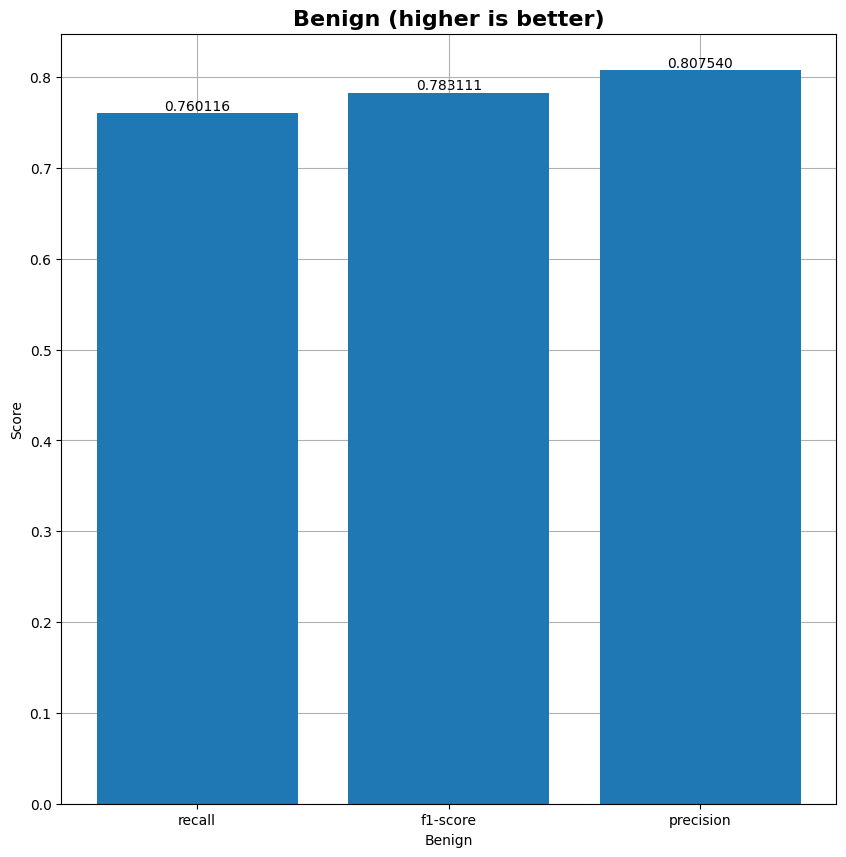

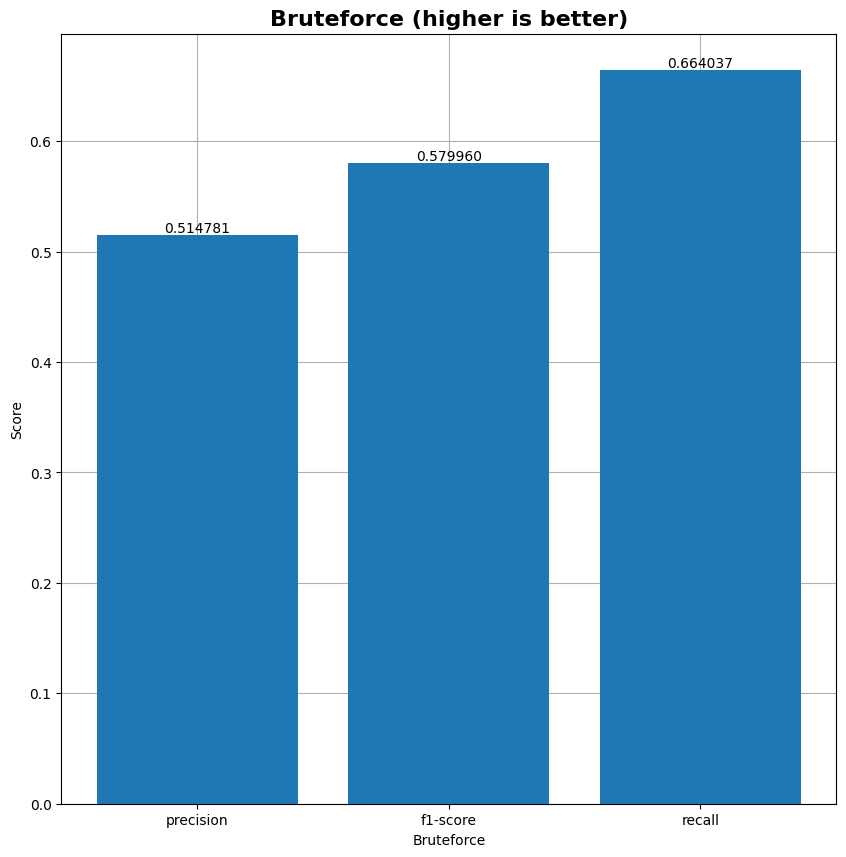

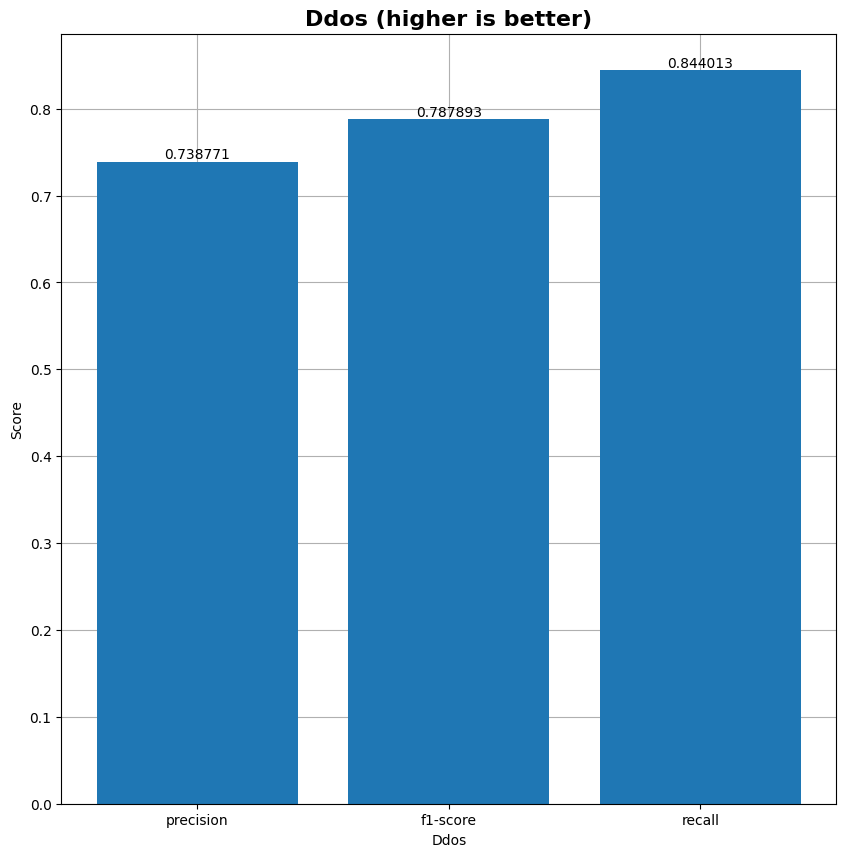

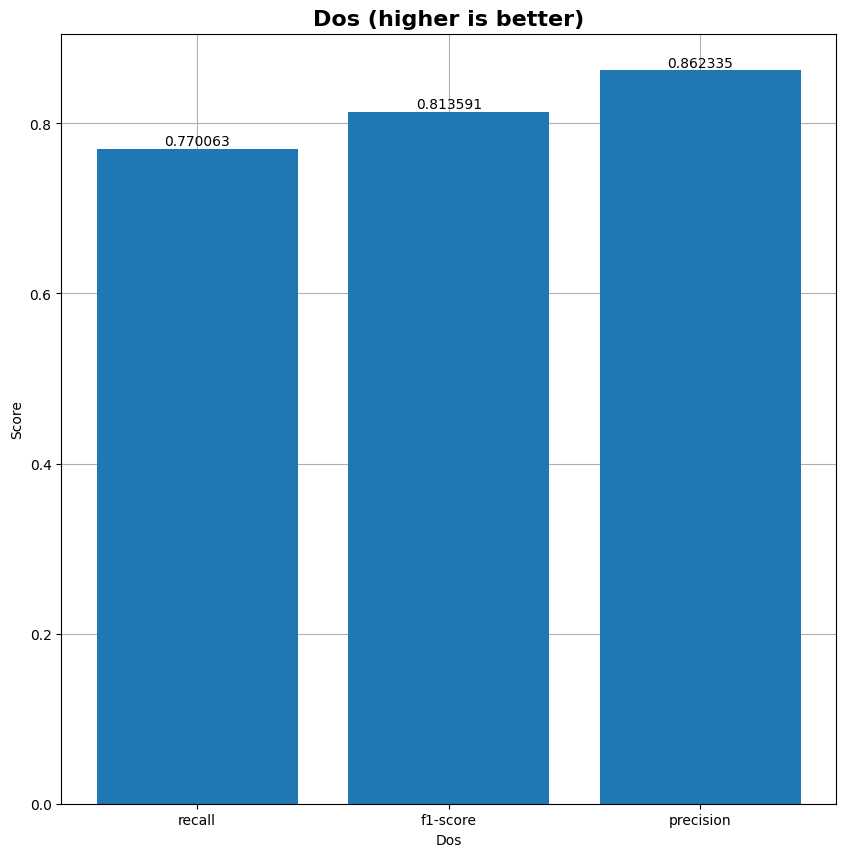

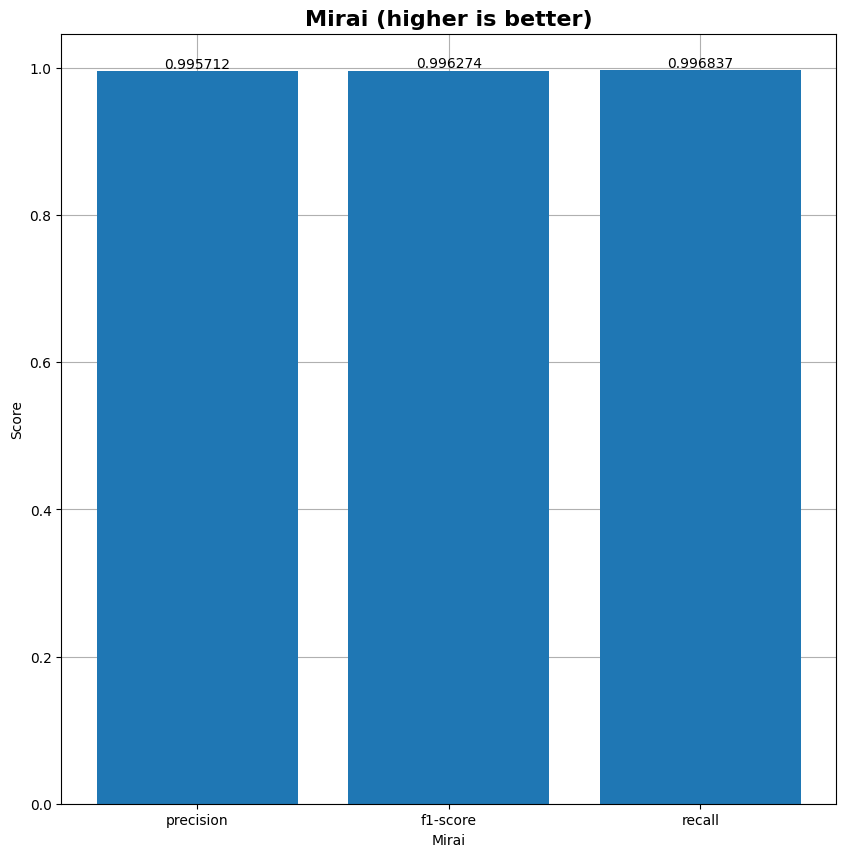

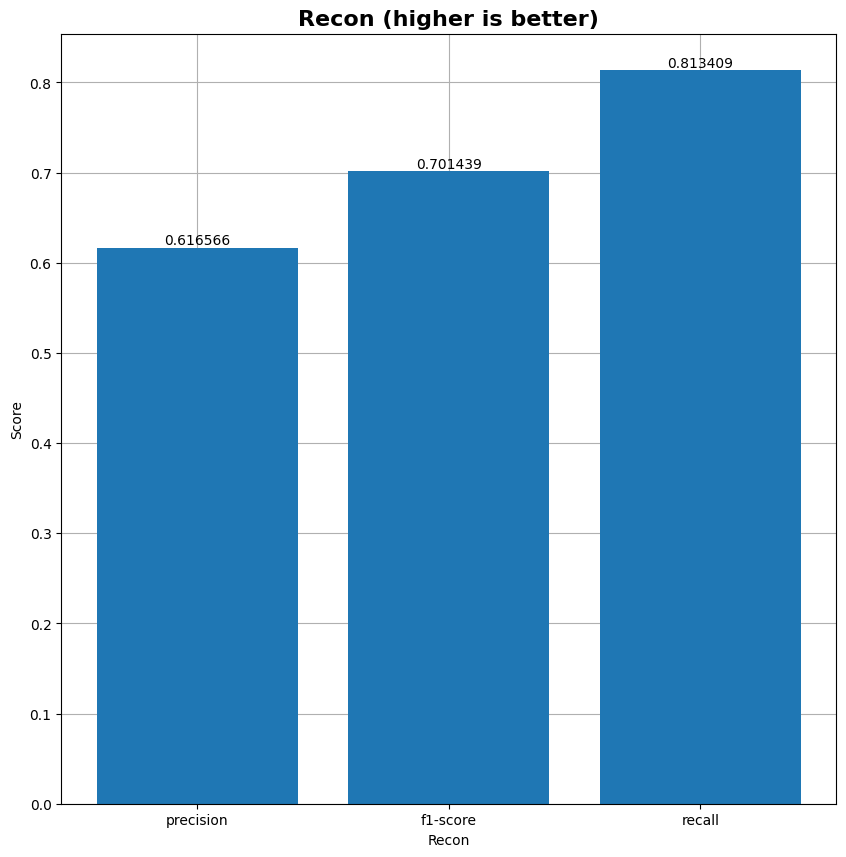

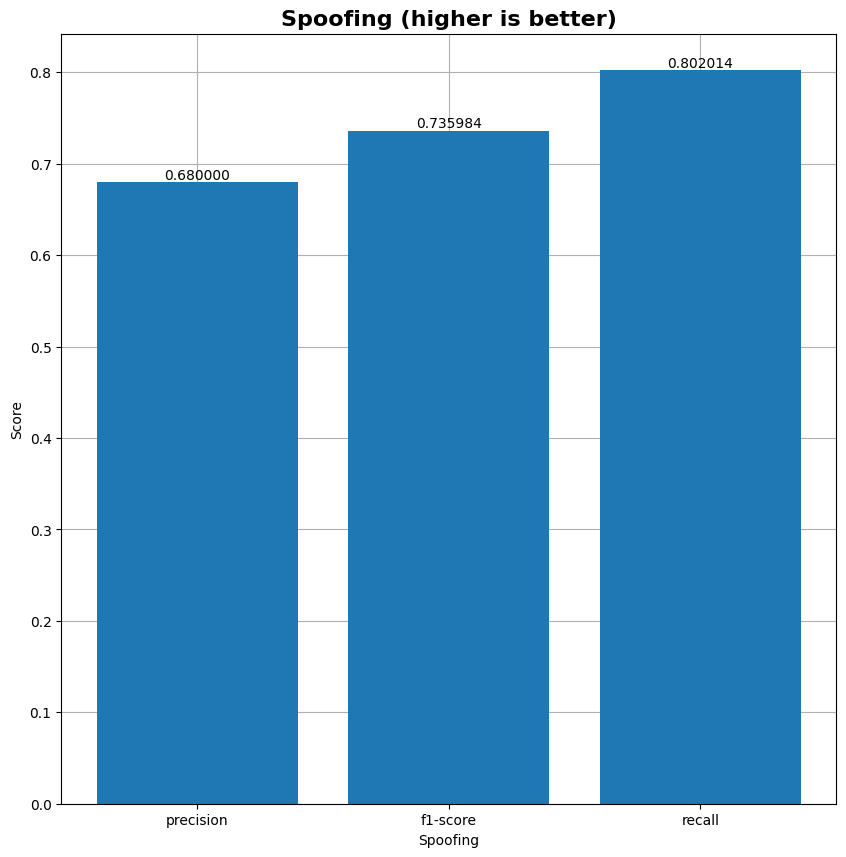

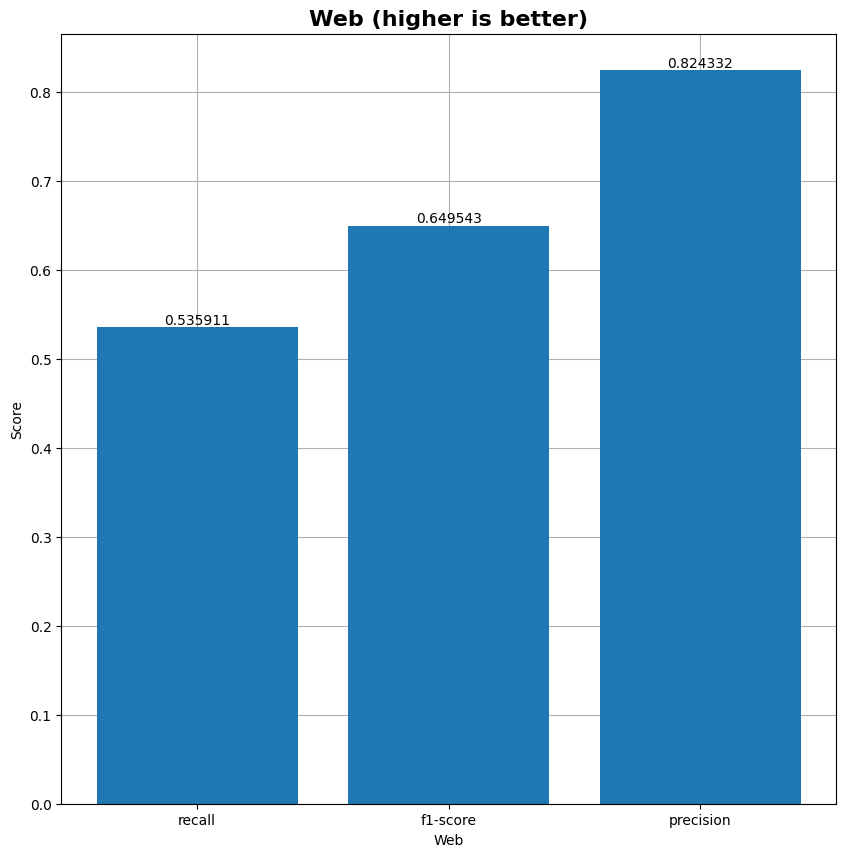

In [65]:
plot_mc(y_pred, y_test, "FF-NN")

In [66]:
model_name = "FFNN_30000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [67]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [68]:
num_components = len(np.unique(y))

In [69]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [70]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [71]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [72]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9637 - loss: 0.1253 - val_accuracy: 0.9977 - val_loss: 0.0076
Epoch 2/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9989 - loss: 0.0050 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 3/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 4/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9998 - val_loss: 9.5047e-04
Epoch 5/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9991 - val_loss: 0.0058
Epoch 6/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 5.9246e-04
Epoch 7/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9998 - loss: 9.1660e-04 - val_accuracy: 0.9999 - val_loss: 3.8631e-04
Epoch 8/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 

In [75]:
_, accuracy = model.evaluate(X_test, y_test)

1022/1022 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 4.1736e-04


In [76]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [77]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [78]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [79]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [80]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.749694,0.753193,0.749712,0.749694,0.712736,0.910476,4.594786,2.143545,9.041801
LR,0.674734,0.682499,0.667833,0.674734,0.627264,1.022090,4.822421,2.196001,886.337639
RF,0.911975,0.914728,0.912087,0.911975,0.899128,0.308989,1.494401,1.222457,10.606501
XGBoost,0.921032,0.923801,0.921109,0.921032,0.909579,0.281973,1.377800,1.173797,6.829646
LightGBM,0.919532,0.922554,0.919607,0.919532,0.907907,0.291182,1.429354,1.195556,5.649458
FF-NN,0.771172,0.787406,0.771751,0.771172,0.739602,0.712734,3.393618,1.842177,409.979707
LSTM,0.999908,0.999908,0.999908,0.999908,0.999894,0.000092,0.000092,0.009581,306.093878


{'precision': {'Benign': 1.0, 'Bruteforce': 1.0, 'DDoS': 1.0, 'DoS': 0.9995544664736021, 'Mirai': 1.0, 'Recon': 0.9997800747745766, 'Spoofing': 1.0, 'Web': 1.0}, 'recall': {'Benign': 1.0, 'Bruteforce': 1.0, 'DDoS': 0.9995529727313366, 'DoS': 1.0, 'Mirai': 1.0, 'Recon': 1.0, 'Spoofing': 0.9997786631252766, 'Web': 1.0}, 'f1-score': {'Benign': 1.0, 'Bruteforce': 1.0, 'DDoS': 0.9997764363961547, 'DoS': 0.999777183600713, 'Mirai': 1.0, 'Recon': 0.9998900252941824, 'Spoofing': 0.9998893193137798, 'Web': 1.0}}


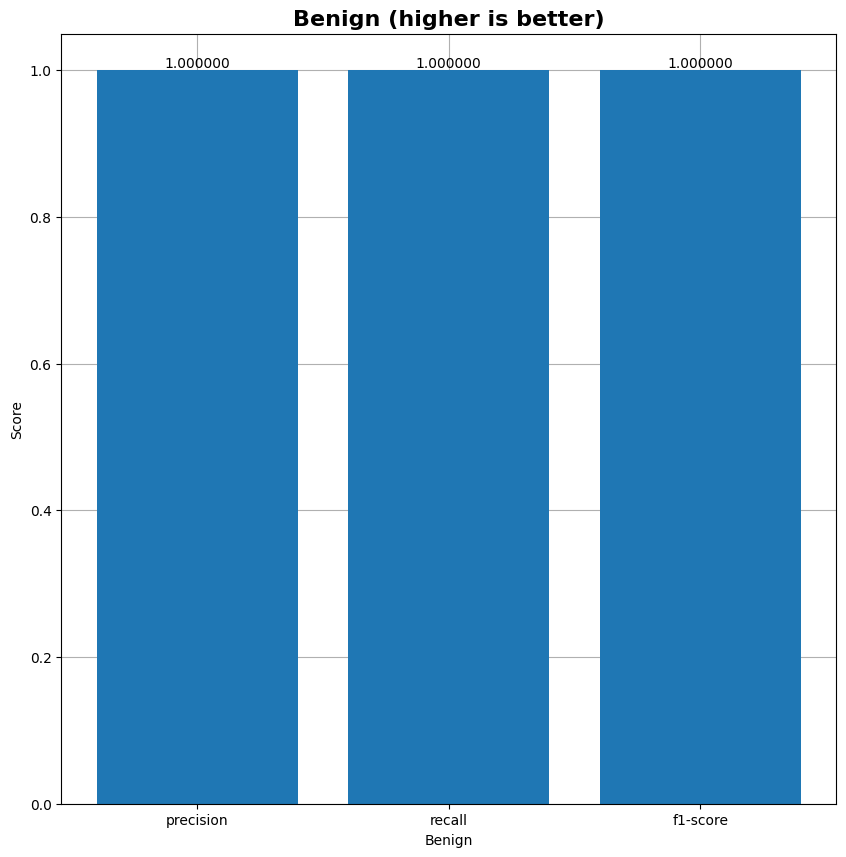

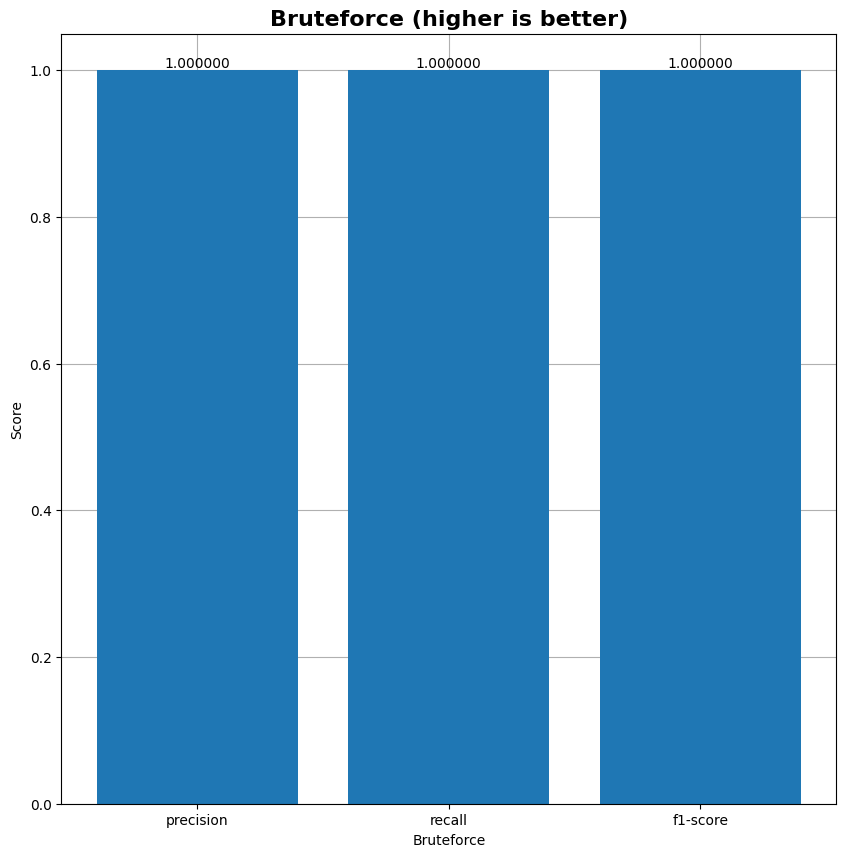

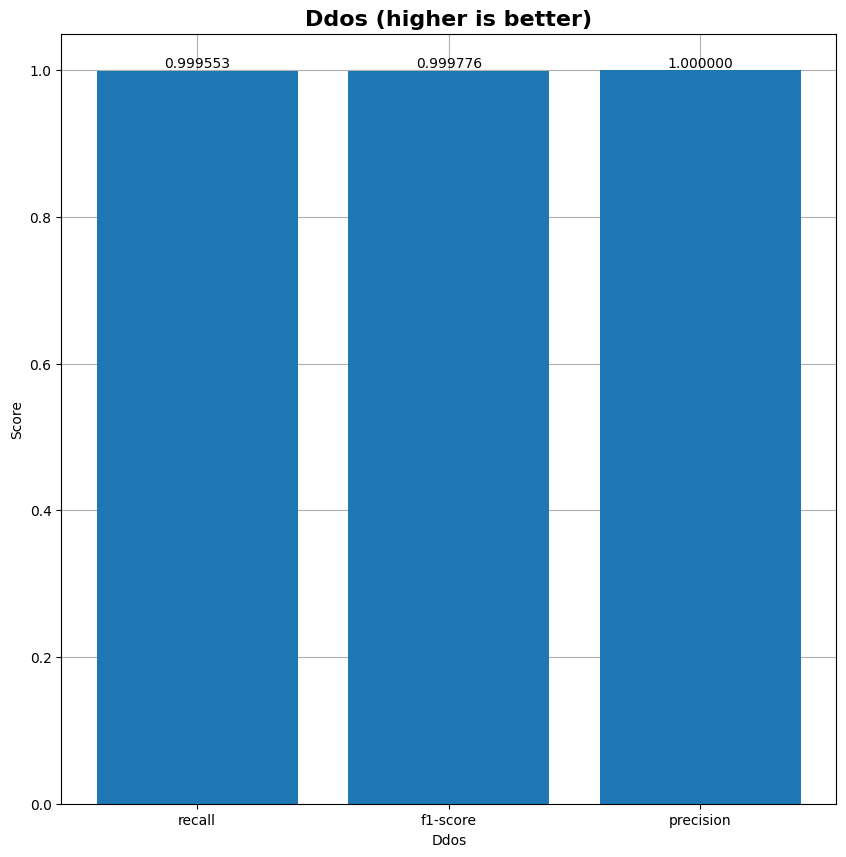

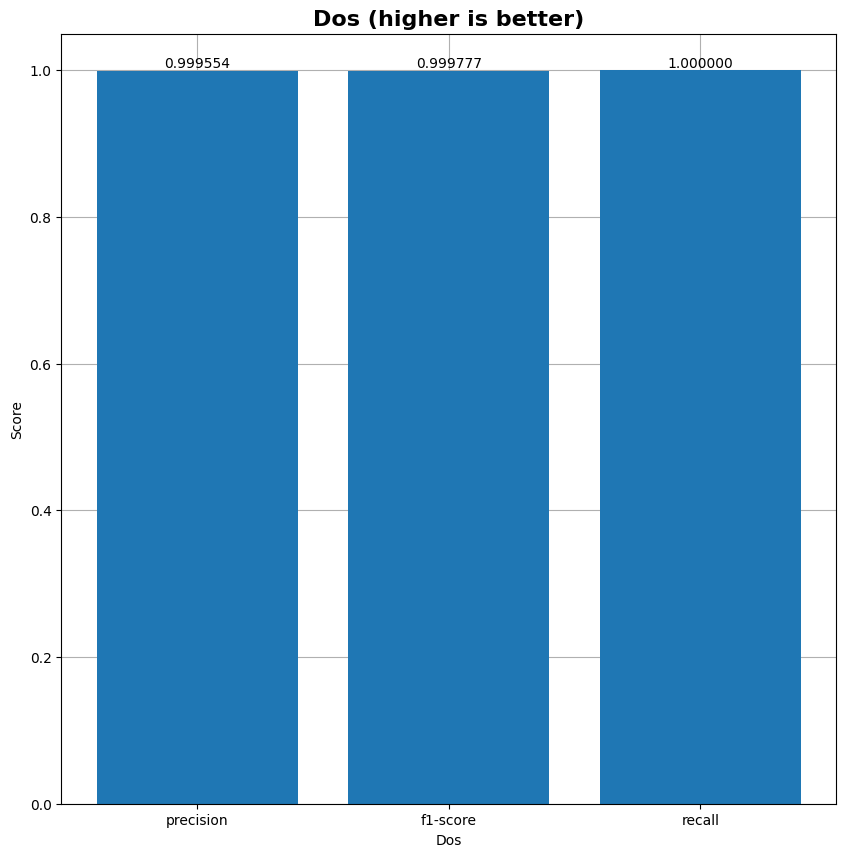

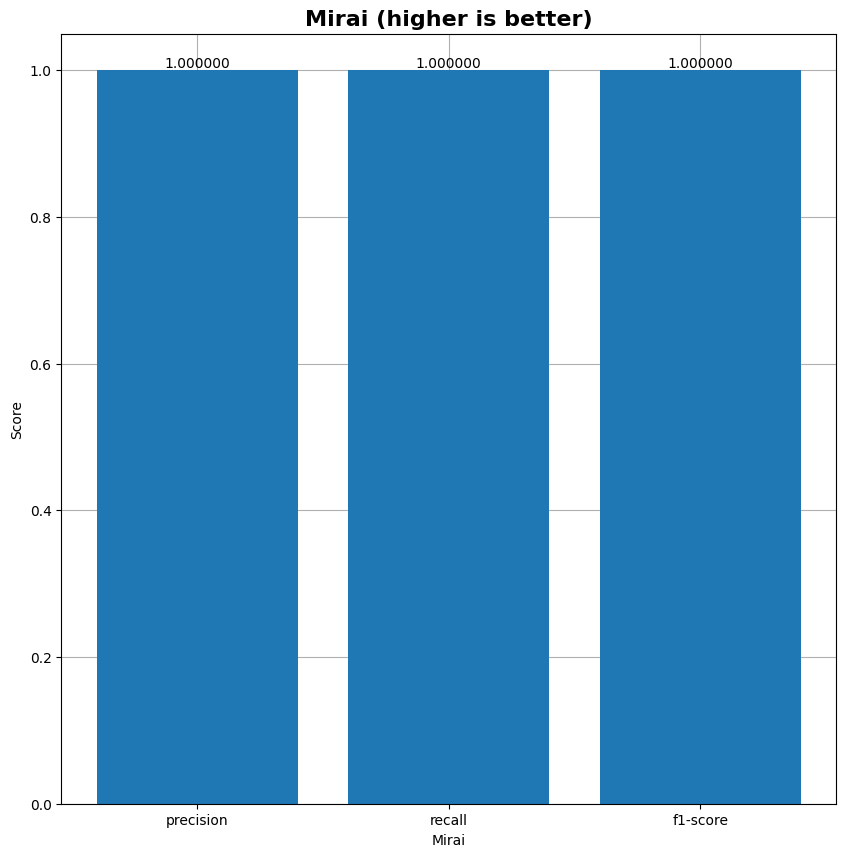

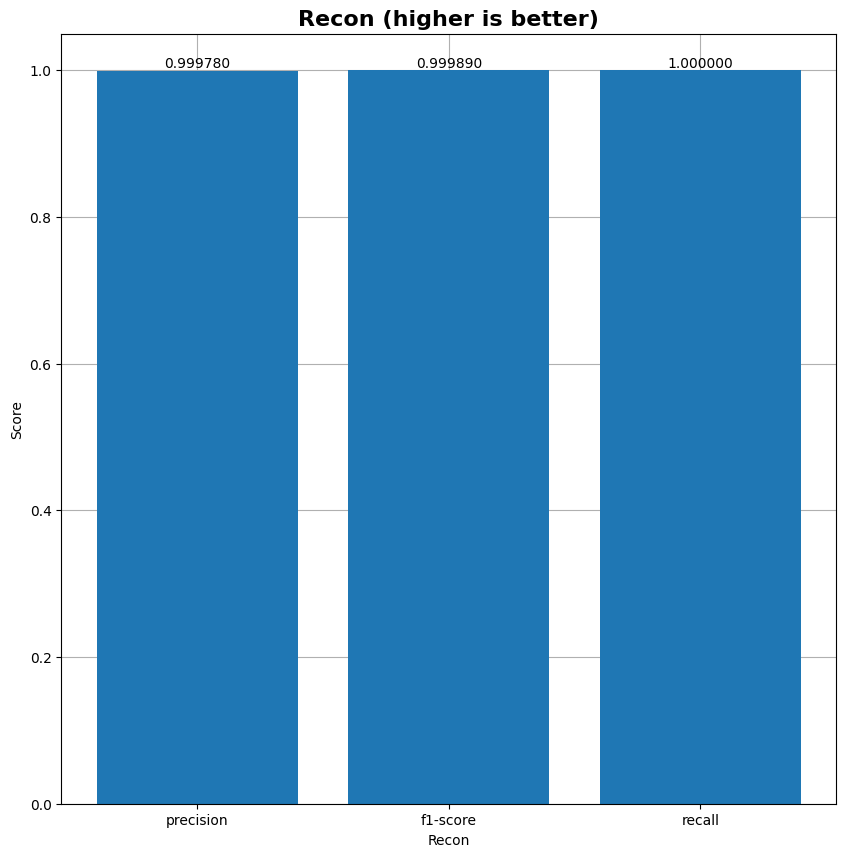

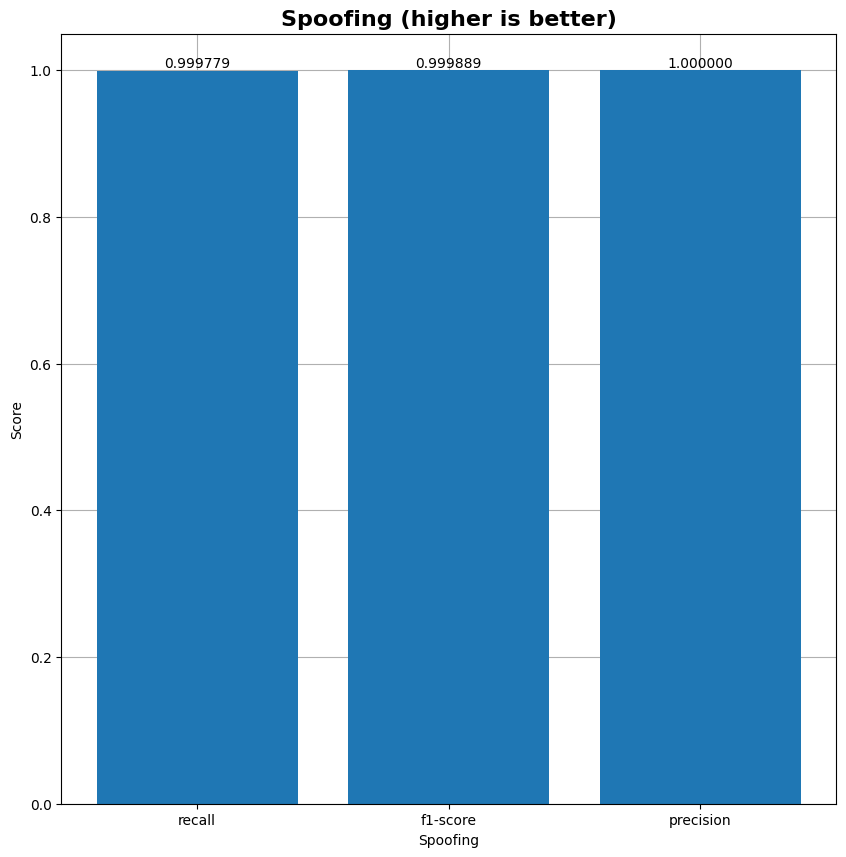

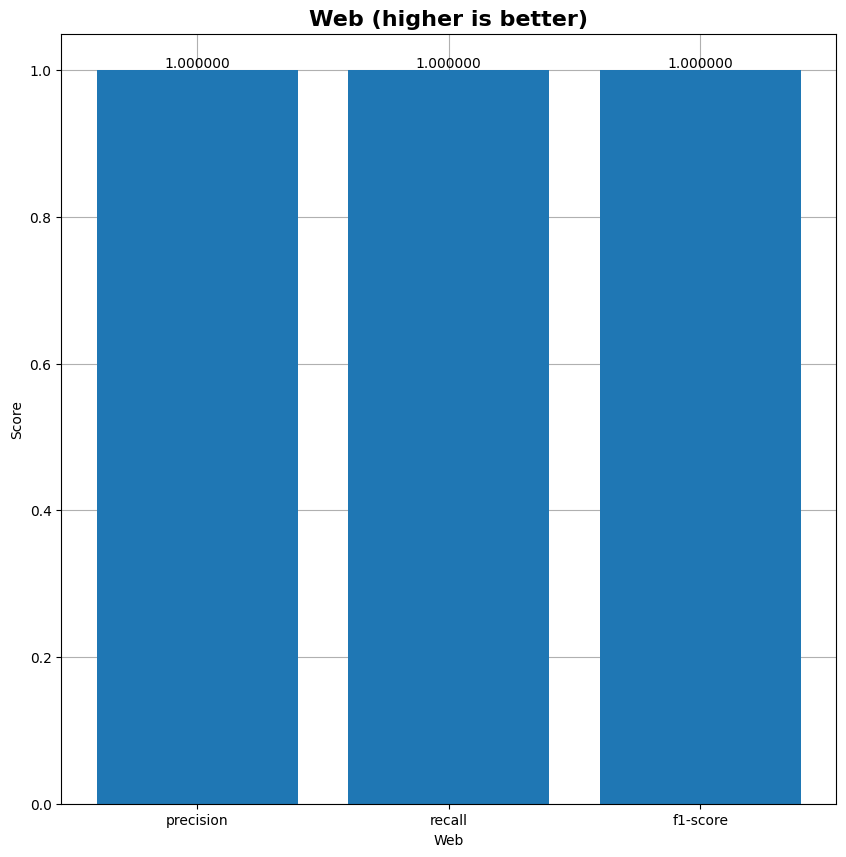

In [81]:
plot_mc(y_pred, y_test, "LSTM")

In [82]:
model_name = "LSTM_30000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

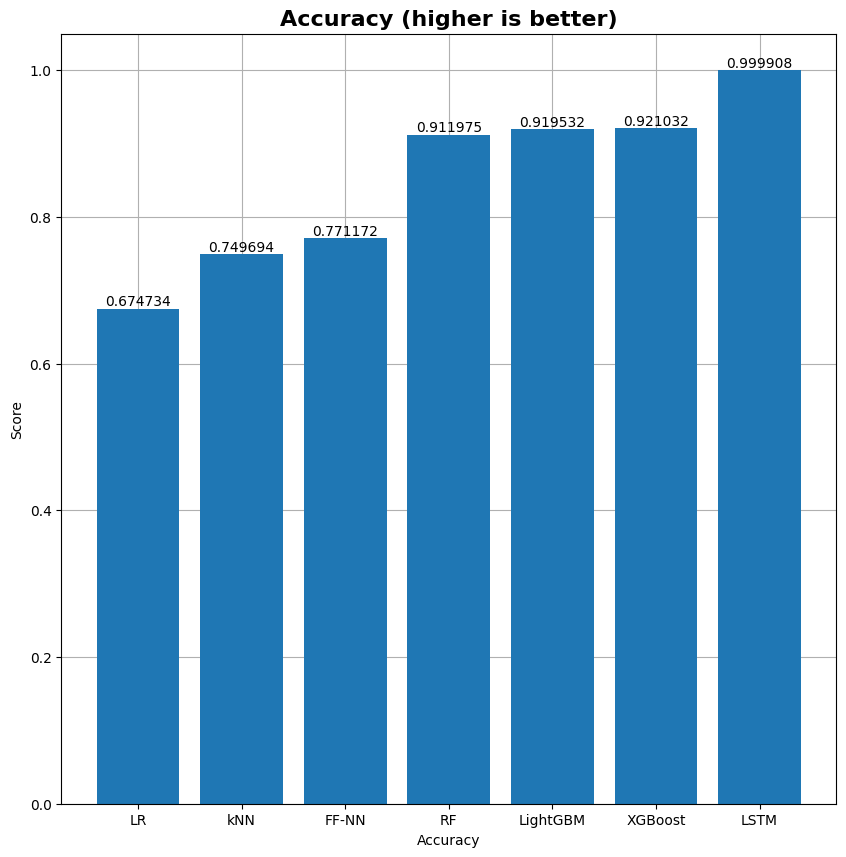

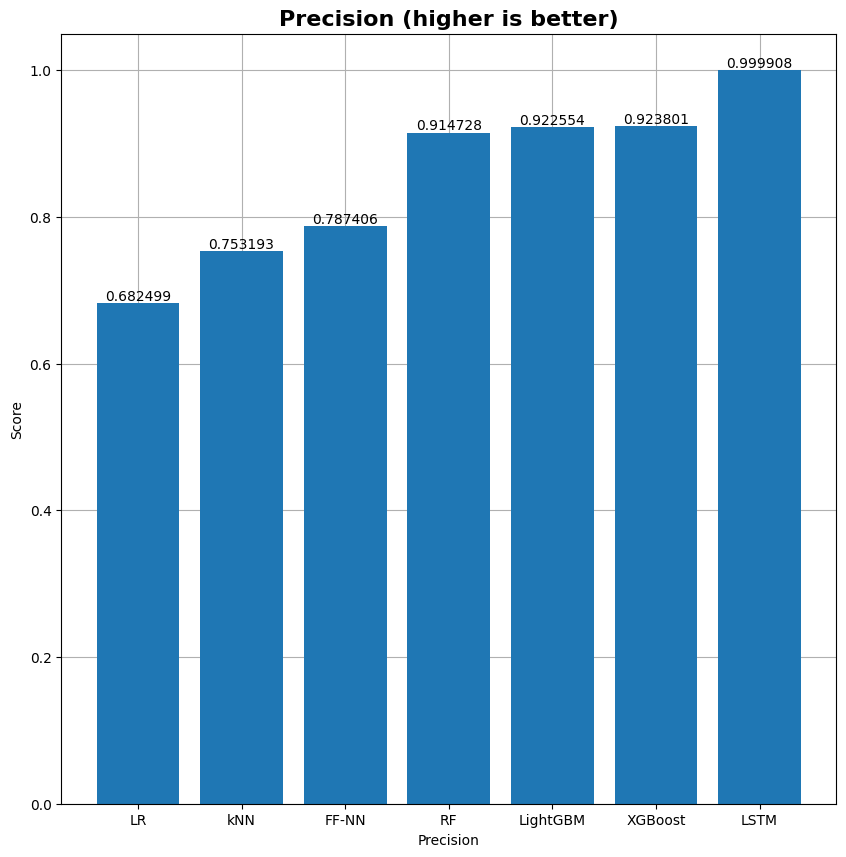

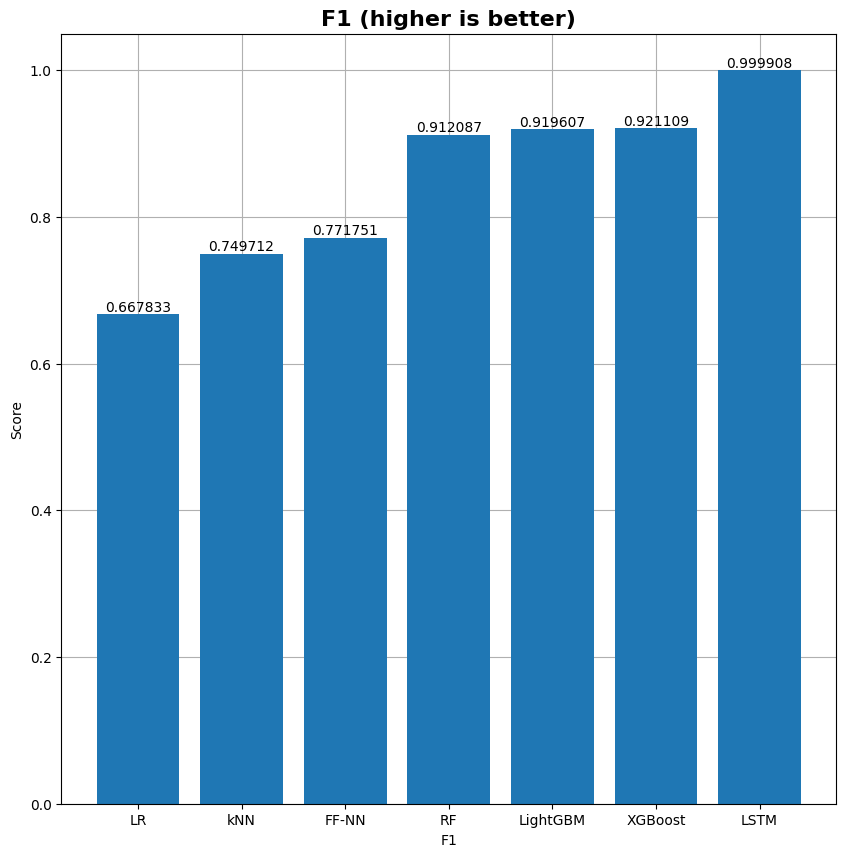

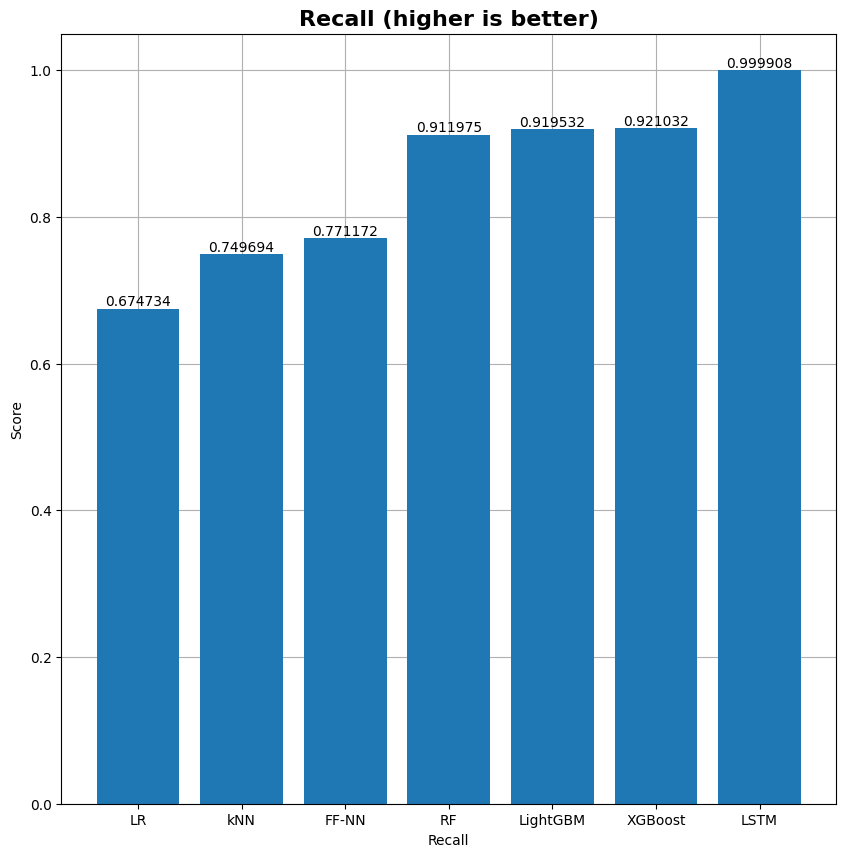

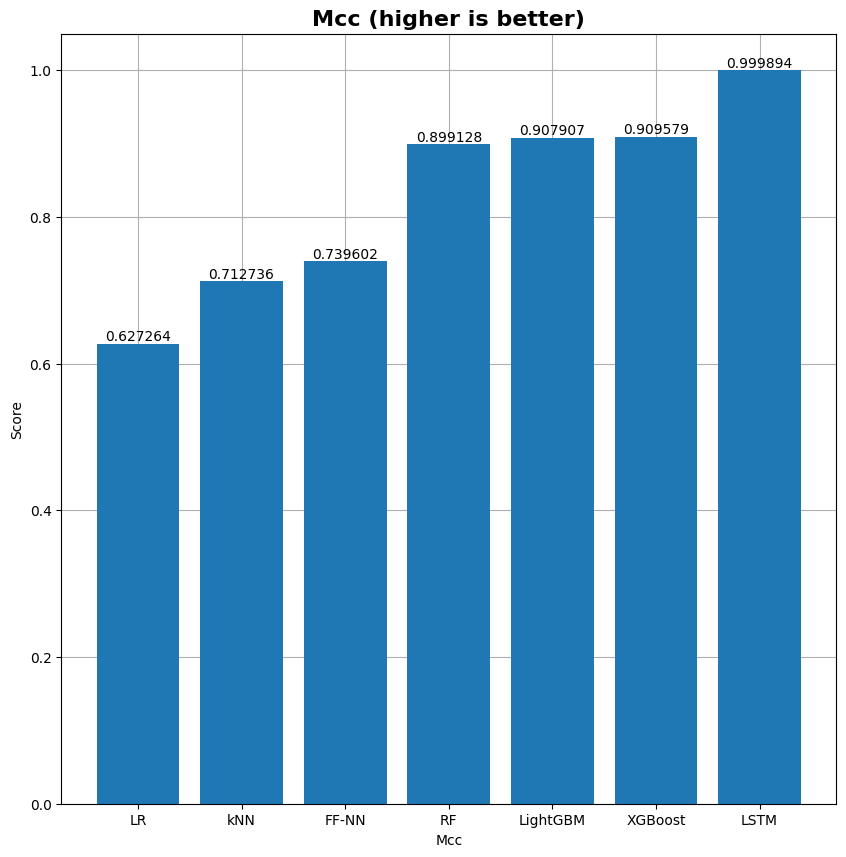

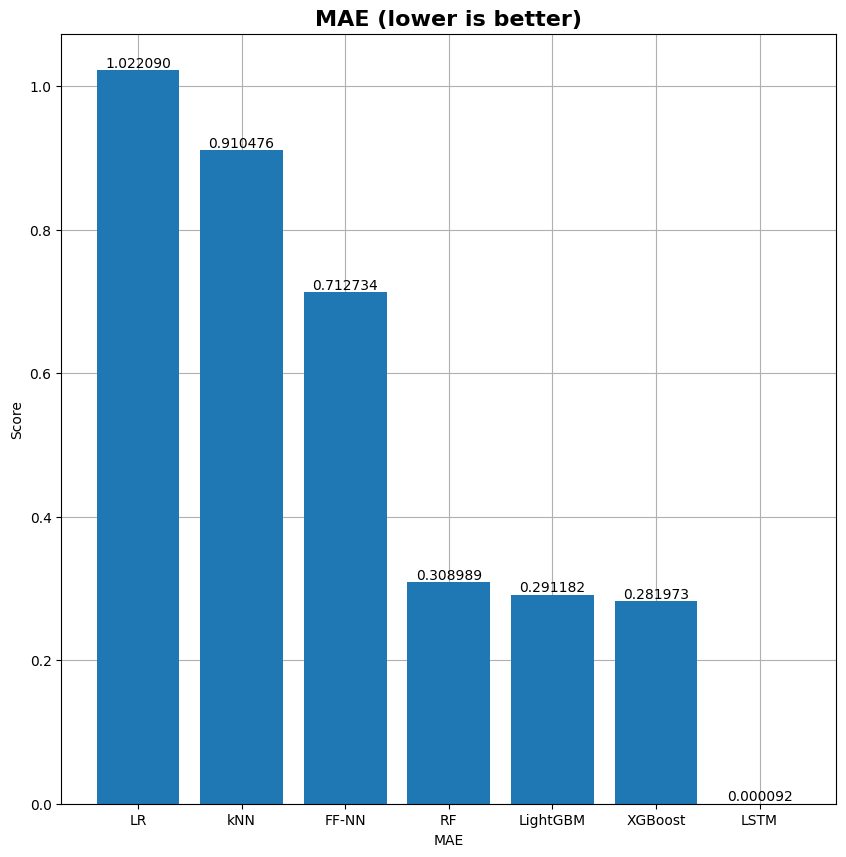

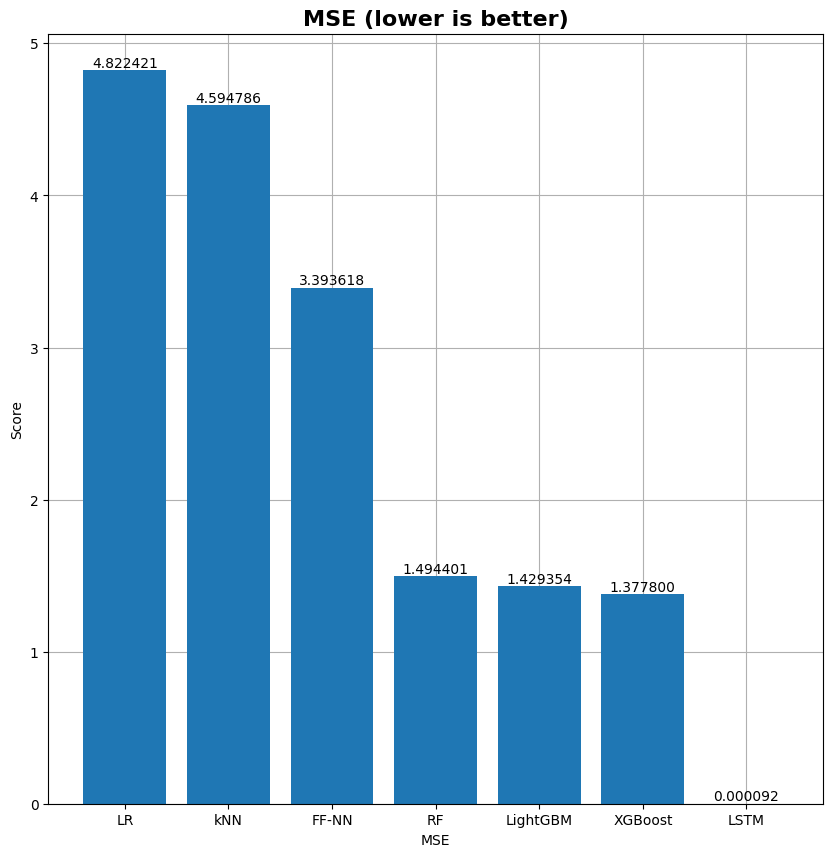

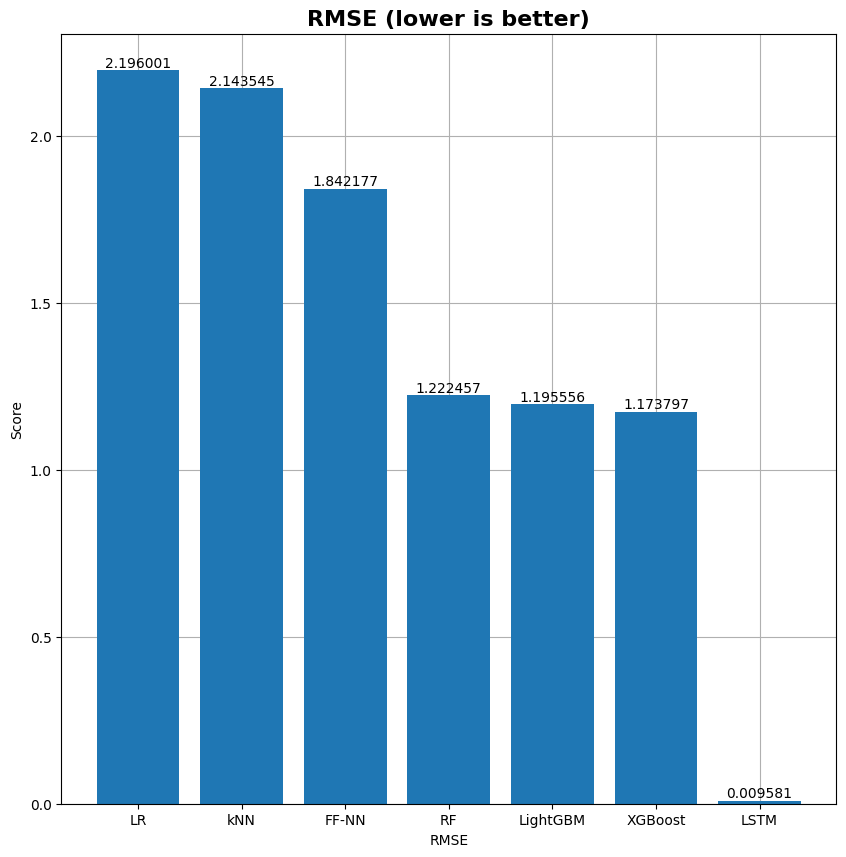

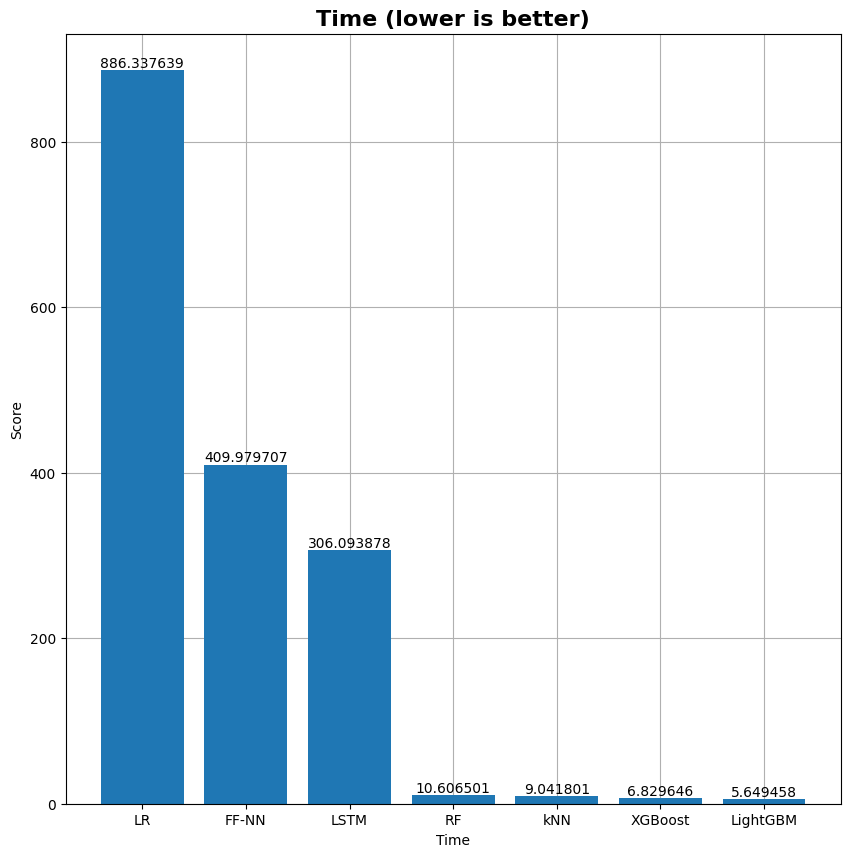

In [83]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [84]:
df_dict = results_df.to_dict()

In [85]:
values = ['Precision', 'Recall', 'F1']
new_dict = {}
for value in values:
    new_dict[value] = df_dict[value]

In [86]:
new_dict

{'Precision': {'kNN': 0.7531925452070118,
  'LR': 0.6824989179571068,
  'RF': 0.9147280115472487,
  'XGBoost': 0.9238008950526937,
  'LightGBM': 0.9225537965178915,
  'FF-NN': 0.7874058826432607,
  'LSTM': 0.9999082376730031},
 'Recall': {'kNN': 0.7496940398971974,
  'LR': 0.6747338147105617,
  'RF': 0.9119752784236935,
  'XGBoost': 0.9210316974666504,
  'LightGBM': 0.9195324929629176,
  'FF-NN': 0.7711724391139395,
  'LSTM': 0.9999082035433432},
 'F1': {'kNN': 0.749711951783182,
  'LR': 0.6678332129819898,
  'RF': 0.9120873332311541,
  'XGBoost': 0.9211086516712208,
  'LightGBM': 0.9196069759712718,
  'FF-NN': 0.7717506643277612,
  'LSTM': 0.9999082035770078}}

In [87]:
pd.DataFrame(new_dict).transpose()

,kNN,LR,RF,XGBoost,LightGBM,FF-NN,LSTM
Precision,0.753193,0.682499,0.914728,0.923801,0.922554,0.787406,0.999908
Recall,0.749694,0.674734,0.911975,0.921032,0.919532,0.771172,0.999908
F1,0.749712,0.667833,0.912087,0.921109,0.919607,0.771751,0.999908
